In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

The cv2 library is used to read the image, resize it and save the numpy array back into an image form.
The tqdm function is used to display the progress bar in the for loop.
The glob function is used to find all the path matching a specified pattern.
Next, from the albumentations library, we import albumentations functions that helps us to transform our image and mask and create an augmented dataset.

In [2]:
import os
import cv2
from tqdm import tqdm
import glob
import albumentations as A

In [3]:
import torch
import torchvision
from torch.utils.data import DataLoader, random_split, Subset, Dataset
from torchvision.transforms import ToTensor
import torch.nn as nn
from PIL import Image

In [4]:
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models

In [5]:
from google.colab import drive
drive.mount('/content/drive')
%cd "drive/MyDrive/Cam101"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Cam101


### Load Data

In [6]:
def load_data(path):
    # Dumping both the images and segmentation in the same list for now
    dump = glob.glob(path + '/*.png')

    # Creating two lists to separate the images and their segmentation
    images=[]
    masks=[]
    
    for f in dump:
        if "_L" not in f:
            images.append(f)
        else:
            masks.append(f)
    
    images=sorted(images)
    masks = sorted(masks)
    return images, masks

Creating Empty Directory
The create_dir function takes a path and create an empty directory if it does not exist.

In [7]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

### Function to augment data

In [8]:
def augment_data(images, masks, save_path, augment=True):
    H = 256
    W = 256

    for x, y in tqdm(zip(images, masks), total=len(images)):
        name = x.split("/")[-1].split(".")
        """ Extracting the name and extension of the image and the mask. """
        image_name = name[0]
        image_extn = name[1]

        name = y.split("/")[-1].split(".")
        mask_name = name[0]
        mask_extn = name[1]

        """ Reading image and mask. """
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        y = cv2.imread(y, cv2.IMREAD_COLOR)

        """ Augmentation """
        if augment == True:
            aug = A.CenterCrop(H, W, p=1.0)
            augmented = aug(image=x, mask=y)
            x1 = augmented["image"]
            y1 = augmented["mask"]

            aug = A.RandomRotate90(p=1.0)
            augmented = aug(image=x, mask=y)
            x2 = augmented['image']
            y2 = augmented['mask']

            aug = A.GridDistortion(p=1.0)
            augmented = aug(image=x, mask=y)
            x3 = augmented['image']
            y3 = augmented['mask']

            aug = A.HorizontalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x4 = augmented['image']
            y4 = augmented['mask']

            aug = A.VerticalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x5 = augmented['image']
            y5 = augmented['mask']

            aug = A.Transpose(p=1)
            augmented = aug(image=x, mask=y)
            x6 = augmented['image']
            y6 = augmented['mask']

            aug = A.RandomSizedCrop(min_max_height=(50, 101), height=H, width=W, p=1)
            augmented = aug(image=x, mask=y)
            x7 = augmented['image']
            y7 = augmented['mask']

            # x_min = (256 - W) // 2
            # y_min = (256 - H) // 2

            # x_max = x_min + W
            # y_max = y_min + H

            # aug = A.Crop(x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max, p=1)
            # augmented = aug(image=x, mask=y)
            # x8 = augmented['image']
            # y8 = augmented['mask']

            save_images = [x, x1, x2, x3, x4, x5, x6, x7]
            save_masks =  [y, y1, y2, y3, y4, y5, y6, y7]

        else:
            save_images = [x]
            save_masks = [y]

        """ Saving the image and mask. """
        idx = 0
        for i, m in zip(save_images, save_masks):
            i = cv2.resize(i, (W, H))
            m = cv2.resize(m, (W, H))

            if len(images) == 1:
                tmp_img_name = f"{image_name}.{image_extn}"
                tmp_mask_name = f"{mask_name}.{mask_extn}"

            else:
                tmp_img_name = f"{image_name}_{idx}.{image_extn}"
                tmp_mask_name = f"{mask_name}_{idx}.{mask_extn}"

            image_path = os.path.join(save_path, "images", tmp_img_name)
            mask_path = os.path.join(save_path, "masks", tmp_mask_name)

            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            idx += 1

In [9]:
path = "train"
images, masks = load_data(path)
print(f"Original Images: {len(images)} - Original Masks: {len(masks)}")

Original Images: 90 - Original Masks: 90


In [10]:
create_dir("new_data/images")
create_dir("new_data/masks")

In [ ]:
augment_data(images, masks, "new_data", augment=True)

100%|██████████| 90/90 [00:20<00:00,  4.42it/s]


### Data after augmentation

In [11]:
path="new_data/masks"
dump = glob.glob(path + '/*.png')

In [12]:
len(dump)

720

### Now that we have augmented the dataset, we will visualize a few examples

In [13]:
label_colors= [ 
(64,128,64),
(192,0,128),
(0,128,192),
(0,128,64),
(128,0,0),
(64,0,128),
(64,0,192),
(192,128,64),
(192,192,128),
(64,64,128),
(128,0,192),
(192,0,64),
(128,128,64),
(192,0,192),
(128,64,64),
(64,192,128),
(64,64,0),
(128,64,128),
(128,128,192),
(0,0,192),
(192,128,128),
(128,128,128),
(64,128,192),
(0,0,64),
(0,64,64),
(192,64,128),
(128,128,0),
(192,128,192),
(64,0,64),
(192,192,0),
(0,0,0),
(64,192,0)
]

In [14]:
class CustomDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        
        self.images = os.listdir(self.image_dir)
        self.masks = os.listdir(self.mask_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # img = np.transpose(img, (2, 0, 1))
        # img = torch.from_numpy(img).float()
        
        mask = cv2.imread(mask_path)
        mask=cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        target_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int32)

        for i, color in enumerate(label_colors):
            mask_i = np.all(mask == color, axis=-1)
            target_mask[mask_i] = i

        target = torch.from_numpy(target_mask).long()

        if self.transform is not None:
            img = self.transform(img)

        return img, target

In [15]:
transform = transforms.Compose([
                 transforms.ToPILImage(),
                 transforms.Resize((256,256)),
                #  transforms.CenterCrop((224,224)),
                 transforms.ToTensor()
                #  ,transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                #              std = [0.229, 0.224, 0.225])
])

### Training Data - I am not normalizing the images yet as they get discolored after normalization. Hence, getting them as is, and would re-reun the transform code with the normalization part before running the models

In [16]:
image_dir = 'new_data/images'
mask_dir = 'new_data/masks'

dataset = CustomDataset(image_dir, mask_dir, transform=transform)

In [17]:
# Define the train/val split
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

### Visualizing the data

### Viz 1

In [ ]:
# Visualizing the data
image, label=train_dataset[215]

In [ ]:
rotate_transform = lambda img: transforms.functional.rotate(img, -180)

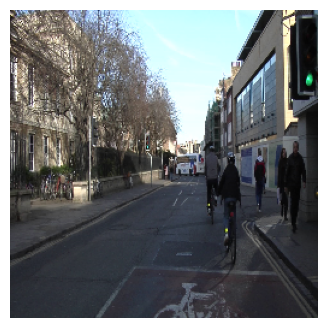

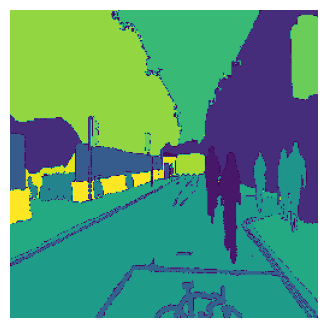

In [ ]:
figure = plt.figure(figsize=(4, 4))
plt.axis("off")
rotated_img = rotate_transform(image)
plt.imshow(np.transpose(rotated_img,(1,2,0)), cmap=None)
plt.show()
figure = plt.figure(figsize=(4, 4))
plt.axis("off")
plt.imshow(np.rot90((label.numpy()), 2), cmap=None)
plt.show()

### Viz-2

In [ ]:
# Visualizing the data
image, label=train_dataset[100]

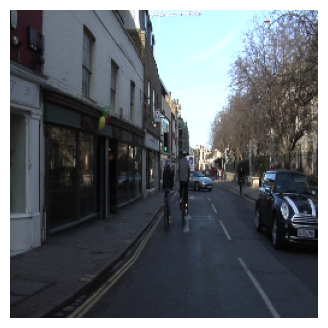

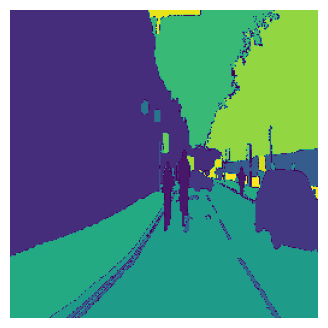

In [ ]:
figure = plt.figure(figsize=(4, 4))
plt.axis("off")
rotated_img = rotate_transform(image)
plt.imshow(np.transpose(image,(1,2,0)), cmap=None)
plt.show()
figure = plt.figure(figsize=(4, 4))
plt.axis("off")
plt.imshow(label.numpy(), cmap=None)
plt.show()

### Now that we have visualized the data, running the transofrm code again and adding normalization

In [18]:
transform = transforms.Compose([
                 transforms.ToPILImage(),
                 transforms.Resize((256,256)),
                #  transforms.CenterCrop((224,224)),
                 transforms.ToTensor()
                 ,transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])
])

In [19]:
image_dir = 'new_data/images'
mask_dir = 'new_data/masks'

dataset = CustomDataset(image_dir, mask_dir, transform=transform)

In [20]:
# Define the train/val split
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [21]:
# Loading the dataset using data loader and making mini-batches
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=4,
    shuffle=True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=4,
    shuffle=False
)

### Testing Data

In [22]:
path='test'
test_images, test_masks = load_data(path)

In [23]:
print("test image size: ",len(test_images))
print("test_mask size: ",len(test_masks))

test image size:  11
test_mask size:  11


In [24]:
create_dir("test_data/images")
create_dir("test_data/masks")

In [ ]:
augment_data(test_images, test_masks, "test_data", augment=False)

100%|██████████| 11/11 [00:26<00:00,  2.38s/it]


In [25]:
path="test_data/masks"
test_dump = glob.glob(path + '/*.png')
print(len(test_dump))

11


In [26]:
image_dir = 'test_data/images'
mask_dir = 'test_data/masks'

test_dataset = CustomDataset(image_dir, mask_dir, transform=transform)

In [27]:
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=4,
    shuffle=False
)

### Printing the size of data

In [28]:
len(train_dataset)

648

In [29]:
len(val_dataset)

72

In [30]:
len(test_dataset)

11

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### We will be using the below library to get the three models along with their backbone and pre-trained weights

In [32]:
!pip install segmentation_models_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=dc715601dc595ad05ebb26fca0d2382bc7c67137f9f2af30a994cd15a3c6b28f
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=eb4e2be61236da802cda2305432d7caeaf99d98b247e27c56f3a1a0a0bae6651
  Stored in directory: /root/.cache/pip/w

In [33]:
import segmentation_models_pytorch as smp

### Defining IoU and Pixel Accuracy function

In [ ]:
##Looking at IoU

def iou(predicted_batch, target_batch, num_classes=32):
    iou_scores = []
    for i in range(num_classes):
        iou_per_class = 0
        for pred, target in zip(predicted_batch, target_batch):
            pred_mask = (pred.argmax(dim=0) == i).float() 
            target_mask = (target.squeeze() == i).float()
            intersection = (pred_mask * target_mask).sum()
            union = (pred_mask + target_mask).sum() - intersection
            iou = (intersection + 1e-6) / (union + 1e-6)
            iou_per_class += iou
        
        iou_per_class /= len(predicted_batch)
        iou_scores.append(iou_per_class.item())

    return np.mean(iou_scores)

In [ ]:
## Looking at Pixel Accuracy

def pixel_acc(predict_batch, target_batch):
  pixel_sum=0

  for pred, target in zip(predict_batch, target_batch):
      
      pred_mask = (pred.argmax(dim=0)).float().cpu().numpy()
      target_mask = (target.squeeze()).float().cpu().numpy()
      correct_pixels = (target_mask == pred_mask).sum()
      total_pixels = torch.numel(target)
      
      pixel_accuracy = correct_pixels / total_pixels
      pixel_sum+= pixel_accuracy

  pixel_sum = pixel_sum/len(target_batch) 

  return (pixel_sum)

# Model 1: DeepLabV3+

In [31]:
model_dl = smp.DeepLabV3Plus(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=32
).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 71.8MB/s]


## We will start tuning our model after choosing a base model and checking its iou score. Then we will keep on tuning the parameters to get better iou and pixel accuracy and will try to achieve the maximum possible



### Base Model: 
### LR=0.001, optimizer = Adam, loss  = Pixel wise entropy

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_dl.parameters(), lr=0.001)

In [ ]:
num_epochs=10
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_dl(inputs)
        loss = criterion(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

        train_loss.append(loss.item())

        # scheduler.step()

    #     for input_batch, target_batch in train_loader:

    #       input_batch=input_batch.to(device)
    #       target_batch=target_batch.to(device)

    #       predict_batch = model_dl(input_batch)

    #       iou_scores = iou(predict_batch, target_batch)
    #       avg_iou_train.append(iou_scores)

    # if (epoch+1)%5==0:
    #   print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')

Epoch number 1
Loss after mini-batch   100: 1.099
time taken for epoch 1 is 314.55
Epoch number 2
Loss after mini-batch   100: 0.634
time taken for epoch 2 is 61.16
Epoch number 3
Loss after mini-batch   100: 0.572
time taken for epoch 3 is 61.30
Epoch number 4
Loss after mini-batch   100: 0.515
time taken for epoch 4 is 61.33
Epoch number 5
Loss after mini-batch   100: 0.476
time taken for epoch 5 is 61.04
Epoch number 6
Loss after mini-batch   100: 0.456
time taken for epoch 6 is 61.67
Epoch number 7
Loss after mini-batch   100: 0.460
time taken for epoch 7 is 60.82
Epoch number 8
Loss after mini-batch   100: 0.390
time taken for epoch 8 is 63.21
Epoch number 9
Loss after mini-batch   100: 0.365
time taken for epoch 9 is 63.47
Epoch number 10
Loss after mini-batch   100: 0.426
time taken for epoch 10 is 66.07
Training process has finished. Time taken is 874.62


In [ ]:
# sets the model in evaluation mode 
model_dl.eval()
print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_dl(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_dl(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.7029725846681205
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.6761535238640678


## Tuning Learning Rate

### LR=0.0001

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_dl.parameters(), lr=0.0001)

In [33]:
num_epochs=10
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_dl(inputs)
        loss = criterion(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

        train_loss.append(loss.item())

        # scheduler.step()

    #     for input_batch, target_batch in train_loader:

    #       input_batch=input_batch.to(device)
    #       target_batch=target_batch.to(device)

    #       predict_batch = model_dl(input_batch)

    #       iou_scores = iou(predict_batch, target_batch)
    #       avg_iou_train.append(iou_scores)

    # if (epoch+1)%5==0:
    #   print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')

Epoch number 1
Loss after mini-batch   100: 1.733
time taken for epoch 1 is 200.83
Epoch number 2
Loss after mini-batch   100: 0.775
time taken for epoch 2 is 64.53
Epoch number 3
Loss after mini-batch   100: 0.618
time taken for epoch 3 is 62.38
Epoch number 4
Loss after mini-batch   100: 0.505
time taken for epoch 4 is 62.17
Epoch number 5
Loss after mini-batch   100: 0.436
time taken for epoch 5 is 62.46
Epoch number 6
Loss after mini-batch   100: 0.375
time taken for epoch 6 is 61.95
Epoch number 7
Loss after mini-batch   100: 0.348
time taken for epoch 7 is 62.11
Epoch number 8
Loss after mini-batch   100: 0.332
time taken for epoch 8 is 62.12
Epoch number 9
Loss after mini-batch   100: 0.295
time taken for epoch 9 is 62.76
Epoch number 10
Loss after mini-batch   100: 0.315
time taken for epoch 10 is 61.81
Training process has finished. Time taken is 763.13


In [34]:
# sets the model in evaluation mode 
model_dl.eval()
print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_dl(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_dl(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.7011274931067603
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.6859148159107968


### LR=0.0005

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_dl.parameters(), lr=0.0005)

In [36]:
num_epochs=10
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_dl(inputs)
        loss = criterion(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

        train_loss.append(loss.item())

        # scheduler.step()

    #     for input_batch, target_batch in train_loader:

    #       input_batch=input_batch.to(device)
    #       target_batch=target_batch.to(device)

    #       predict_batch = model_dl(input_batch)

    #       iou_scores = iou(predict_batch, target_batch)
    #       avg_iou_train.append(iou_scores)

    # if (epoch+1)%5==0:
    #   print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')

Epoch number 1
Loss after mini-batch   100: 2.114
time taken for epoch 1 is 61.95
Epoch number 2
Loss after mini-batch   100: 0.732
time taken for epoch 2 is 60.53
Epoch number 3
Loss after mini-batch   100: 0.524
time taken for epoch 3 is 61.64
Epoch number 4
Loss after mini-batch   100: 0.507
time taken for epoch 4 is 60.86
Epoch number 5
Loss after mini-batch   100: 0.459
time taken for epoch 5 is 61.41
Epoch number 6
Loss after mini-batch   100: 0.416
time taken for epoch 6 is 62.10
Epoch number 7
Loss after mini-batch   100: 0.388
time taken for epoch 7 is 61.49
Epoch number 8
Loss after mini-batch   100: 0.386
time taken for epoch 8 is 62.56
Epoch number 9
Loss after mini-batch   100: 0.350
time taken for epoch 9 is 61.46
Epoch number 10
Loss after mini-batch   100: 0.354
time taken for epoch 10 is 62.58
Training process has finished. Time taken is 616.58


In [37]:
# sets the model in evaluation mode 
model_dl.eval()
print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_dl(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_dl(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.6915590994488644
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.6738981350174166


### LR=0.005

In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_dl.parameters(), lr=0.005)

In [39]:
num_epochs=10
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_dl(inputs)
        loss = criterion(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

        train_loss.append(loss.item())

        # scheduler.step()

    #     for input_batch, target_batch in train_loader:

    #       input_batch=input_batch.to(device)
    #       target_batch=target_batch.to(device)

    #       predict_batch = model_dl(input_batch)

    #       iou_scores = iou(predict_batch, target_batch)
    #       avg_iou_train.append(iou_scores)

    # if (epoch+1)%5==0:
    #   print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')

Epoch number 1
Loss after mini-batch   100: 49.378
time taken for epoch 1 is 61.79
Epoch number 2
Loss after mini-batch   100: 169.092
time taken for epoch 2 is 61.17
Epoch number 3
Loss after mini-batch   100: 2.424
time taken for epoch 3 is 62.42
Epoch number 4
Loss after mini-batch   100: 2.260
time taken for epoch 4 is 61.03
Epoch number 5
Loss after mini-batch   100: 2.209
time taken for epoch 5 is 62.12
Epoch number 6
Loss after mini-batch   100: 2.183
time taken for epoch 6 is 61.14
Epoch number 7
Loss after mini-batch   100: 2.163
time taken for epoch 7 is 62.12
Epoch number 8
Loss after mini-batch   100: 2.170
time taken for epoch 8 is 61.17
Epoch number 9
Loss after mini-batch   100: 2.151
time taken for epoch 9 is 64.77
Epoch number 10
Loss after mini-batch   100: 2.166
time taken for epoch 10 is 61.03
Training process has finished. Time taken is 618.78


In [40]:
# sets the model in evaluation mode 
model_dl.eval()
print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_dl(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_dl(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.4483239432562379
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.4599516710466772


## Optimizer

### LR = 0.0001, optimizer = SGD

In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_dl.parameters(), lr=0.0001, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.15)

In [42]:
num_epochs=10
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_dl(inputs)
        loss = criterion(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

        train_loss.append(loss.item())

        # scheduler.step()

    #     for input_batch, target_batch in train_loader:

    #       input_batch=input_batch.to(device)
    #       target_batch=target_batch.to(device)

    #       predict_batch = model_dl(input_batch)

    #       iou_scores = iou(predict_batch, target_batch)
    #       avg_iou_train.append(iou_scores)

    # if (epoch+1)%5==0:
    #   print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')

Epoch number 1
Loss after mini-batch   100: 2.136
time taken for epoch 1 is 59.94
Epoch number 2
Loss after mini-batch   100: 2.158
time taken for epoch 2 is 60.43
Epoch number 3
Loss after mini-batch   100: 2.146
time taken for epoch 3 is 61.29
Epoch number 4
Loss after mini-batch   100: 2.146
time taken for epoch 4 is 60.66
Epoch number 5
Loss after mini-batch   100: 2.133
time taken for epoch 5 is 61.23
Epoch number 6
Loss after mini-batch   100: 2.139
time taken for epoch 6 is 60.29
Epoch number 7
Loss after mini-batch   100: 2.149
time taken for epoch 7 is 63.61
Epoch number 8
Loss after mini-batch   100: 2.156
time taken for epoch 8 is 60.82
Epoch number 9
Loss after mini-batch   100: 2.152
time taken for epoch 9 is 60.62
Epoch number 10
Loss after mini-batch   100: 2.150
time taken for epoch 10 is 61.20
Training process has finished. Time taken is 610.10


In [44]:
# sets the model in evaluation mode 
model_dl.eval()
print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_dl(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_dl(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.44832394313678353
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.4599516710466772


### LR = 0.0001, optimizer = RMSProp

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model_dl.parameters(), lr=0.0001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.15)

In [32]:
num_epochs=10
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_dl(inputs)
        loss = criterion(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

        train_loss.append(loss.item())

        # scheduler.step()

    #     for input_batch, target_batch in train_loader:

    #       input_batch=input_batch.to(device)
    #       target_batch=target_batch.to(device)

    #       predict_batch = model_dl(input_batch)

    #       iou_scores = iou(predict_batch, target_batch)
    #       avg_iou_train.append(iou_scores)

    # if (epoch+1)%5==0:
    #   print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')

Epoch number 1
Loss after mini-batch   100: 1.174
time taken for epoch 1 is 710.89
Epoch number 2
Loss after mini-batch   100: 0.632
time taken for epoch 2 is 63.86
Epoch number 3
Loss after mini-batch   100: 0.525
time taken for epoch 3 is 64.79
Epoch number 4
Loss after mini-batch   100: 0.460
time taken for epoch 4 is 64.50
Epoch number 5
Loss after mini-batch   100: 0.383
time taken for epoch 5 is 64.61
Epoch number 6
Loss after mini-batch   100: 0.353
time taken for epoch 6 is 65.27
Epoch number 7
Loss after mini-batch   100: 0.312
time taken for epoch 7 is 64.07
Epoch number 8
Loss after mini-batch   100: 0.326
time taken for epoch 8 is 65.04
Epoch number 9
Loss after mini-batch   100: 0.291
time taken for epoch 9 is 64.59
Epoch number 10
Loss after mini-batch   100: 0.294
time taken for epoch 10 is 64.63
Training process has finished. Time taken is 1292.24


In [33]:
# sets the model in evaluation mode 
model_dl.eval()
print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_dl(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_dl(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.7231823479645569
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.7296699238005485


### LR = 0.0001, optimizer = Adam

In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_dl.parameters(), lr=0.0001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.15)

In [35]:
num_epochs=10
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_dl(inputs)
        loss = criterion(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

        train_loss.append(loss.item())

        # scheduler.step()

    #     for input_batch, target_batch in train_loader:

    #       input_batch=input_batch.to(device)
    #       target_batch=target_batch.to(device)

    #       predict_batch = model_dl(input_batch)

    #       iou_scores = iou(predict_batch, target_batch)
    #       avg_iou_train.append(iou_scores)

    # if (epoch+1)%5==0:
    #   print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')

Epoch number 1
Loss after mini-batch   100: 0.302
time taken for epoch 1 is 70.57
Epoch number 2
Loss after mini-batch   100: 0.324
time taken for epoch 2 is 65.66
Epoch number 3
Loss after mini-batch   100: 0.315
time taken for epoch 3 is 64.72
Epoch number 4
Loss after mini-batch   100: 0.300
time taken for epoch 4 is 64.98
Epoch number 5
Loss after mini-batch   100: 0.218
time taken for epoch 5 is 64.97
Epoch number 6
Loss after mini-batch   100: 0.229
time taken for epoch 6 is 64.77
Epoch number 7
Loss after mini-batch   100: 0.204
time taken for epoch 7 is 65.24
Epoch number 8
Loss after mini-batch   100: 0.266
time taken for epoch 8 is 63.91
Epoch number 9
Loss after mini-batch   100: 0.303
time taken for epoch 9 is 65.29
Epoch number 10
Loss after mini-batch   100: 0.247
time taken for epoch 10 is 64.31
Training process has finished. Time taken is 654.43


In [36]:
# sets the model in evaluation mode 
model_dl.eval()
print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_dl(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_dl(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.7447690089387367
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.7428483410512329


## Learning Rate Scheduler

### LR -Step LR - Gamma - 0.10

In [37]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_dl.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.10)

In [38]:
num_epochs=10
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_dl(inputs)
        loss = criterion(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

        train_loss.append(loss.item())

        scheduler.step()

    #     for input_batch, target_batch in train_loader:

    #       input_batch=input_batch.to(device)
    #       target_batch=target_batch.to(device)

    #       predict_batch = model_dl(input_batch)

    #       iou_scores = iou(predict_batch, target_batch)
    #       avg_iou_train.append(iou_scores)

    # if (epoch+1)%5==0:
    #   print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')

Epoch number 1
Loss after mini-batch   100: 0.210
time taken for epoch 1 is 72.01
Epoch number 2
Loss after mini-batch   100: 0.215
time taken for epoch 2 is 65.84
Epoch number 3
Loss after mini-batch   100: 0.218
time taken for epoch 3 is 64.39
Epoch number 4
Loss after mini-batch   100: 0.217
time taken for epoch 4 is 83.91
Epoch number 5
Loss after mini-batch   100: 0.216
time taken for epoch 5 is 65.53
Epoch number 6
Loss after mini-batch   100: 0.216
time taken for epoch 6 is 65.01
Epoch number 7
Loss after mini-batch   100: 0.216
time taken for epoch 7 is 69.47
Epoch number 8
Loss after mini-batch   100: 0.221
time taken for epoch 8 is 67.57
Epoch number 9
Loss after mini-batch   100: 0.216
time taken for epoch 9 is 65.20
Epoch number 10
Loss after mini-batch   100: 0.215
time taken for epoch 10 is 64.21
Training process has finished. Time taken is 683.13


In [39]:
# sets the model in evaluation mode 
model_dl.eval()
print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_dl(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_dl(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.738728298002712
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.7388871538831437


## Scheduler StepLR - gamma =0.15

In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_dl.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.15)

In [41]:
num_epochs=5
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_dl(inputs)
        loss = criterion(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

        train_loss.append(loss.item())

        scheduler.step()

    #     for input_batch, target_batch in train_loader:

    #       input_batch=input_batch.to(device)
    #       target_batch=target_batch.to(device)

    #       predict_batch = model_dl(input_batch)

    #       iou_scores = iou(predict_batch, target_batch)
    #       avg_iou_train.append(iou_scores)

    # if (epoch+1)%5==0:
    #   print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')

Epoch number 1
Loss after mini-batch   100: 0.210
time taken for epoch 1 is 65.61
Epoch number 2
Loss after mini-batch   100: 0.215
time taken for epoch 2 is 64.67
Epoch number 3
Loss after mini-batch   100: 0.208
time taken for epoch 3 is 80.01
Epoch number 4
Loss after mini-batch   100: 0.209
time taken for epoch 4 is 68.95
Epoch number 5
Loss after mini-batch   100: 0.210
time taken for epoch 5 is 64.91
Training process has finished. Time taken is 344.16


In [42]:
# sets the model in evaluation mode 
model_dl.eval()
print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_dl(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_dl(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.7430495829294889
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.7389220109424449


## Scheduler ReduceLR on Plateau

In [43]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_dl.parameters(), lr=0.0001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.15)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [45]:
num_epochs=5
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_dl(inputs)
        loss = criterion(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

        train_loss.append(loss.item())

        scheduler.step(current_loss)

    #     for input_batch, target_batch in train_loader:

    #       input_batch=input_batch.to(device)
    #       target_batch=target_batch.to(device)

    #       predict_batch = model_dl(input_batch)

    #       iou_scores = iou(predict_batch, target_batch)
    #       avg_iou_train.append(iou_scores)

    # if (epoch+1)%5==0:
    #   print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')

Epoch number 1
Loss after mini-batch   100: 0.226
time taken for epoch 1 is 70.62
Epoch number 2
Loss after mini-batch   100: 0.227
time taken for epoch 2 is 74.94
Epoch number 3
Loss after mini-batch   100: 0.218
time taken for epoch 3 is 65.05
Epoch number 4
Loss after mini-batch   100: 0.224
time taken for epoch 4 is 64.07
Epoch number 5
Loss after mini-batch   100: 0.224
time taken for epoch 5 is 64.63
Training process has finished. Time taken is 339.32


In [46]:
# sets the model in evaluation mode 
model_dl.eval()
print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_dl(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_dl(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.7359662329457635
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.7355108249445637


## No Scheduler

In [47]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_dl.parameters(), lr=0.0001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.15)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [48]:
num_epochs=5
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_dl(inputs)
        loss = criterion(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

        train_loss.append(loss.item())

        # scheduler.step()

    #     for input_batch, target_batch in train_loader:

    #       input_batch=input_batch.to(device)
    #       target_batch=target_batch.to(device)

    #       predict_batch = model_dl(input_batch)

    #       iou_scores = iou(predict_batch, target_batch)
    #       avg_iou_train.append(iou_scores)

    # if (epoch+1)%5==0:
    #   print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')

Epoch number 1
Loss after mini-batch   100: 0.254
time taken for epoch 1 is 64.72
Epoch number 2
Loss after mini-batch   100: 0.215
time taken for epoch 2 is 63.62
Epoch number 3
Loss after mini-batch   100: 0.232
time taken for epoch 3 is 63.52
Epoch number 4
Loss after mini-batch   100: 0.259
time taken for epoch 4 is 63.26
Epoch number 5
Loss after mini-batch   100: 0.219
time taken for epoch 5 is 63.28
Training process has finished. Time taken is 318.40


In [49]:
# sets the model in evaluation mode 
model_dl.eval()
print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_dl(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_dl(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.7516862551492245
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.7553184645625556


## Weight Decay = 0.0001

In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_dl.parameters(), lr=0.0001, weight_decay=0.0001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.15)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [51]:
num_epochs=5
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_dl(inputs)
        loss = criterion(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

        train_loss.append(loss.item())

        # scheduler.step()

    #     for input_batch, target_batch in train_loader:

    #       input_batch=input_batch.to(device)
    #       target_batch=target_batch.to(device)

    #       predict_batch = model_dl(input_batch)

    #       iou_scores = iou(predict_batch, target_batch)
    #       avg_iou_train.append(iou_scores)

    # if (epoch+1)%5==0:
    #   print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')

Epoch number 1
Loss after mini-batch   100: 0.220
time taken for epoch 1 is 72.82
Epoch number 2
Loss after mini-batch   100: 0.214
time taken for epoch 2 is 66.78
Epoch number 3
Loss after mini-batch   100: 0.185
time taken for epoch 3 is 65.35
Epoch number 4
Loss after mini-batch   100: 0.332
time taken for epoch 4 is 64.88
Epoch number 5
Loss after mini-batch   100: 0.211
time taken for epoch 5 is 65.68
Training process has finished. Time taken is 335.53


In [52]:
# sets the model in evaluation mode 
model_dl.eval()
print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_dl(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_dl(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.74466546469428
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.7321349563135178


## Weight Decay = 0.0005

In [53]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_dl.parameters(), lr=0.0001, weight_decay=0.0005)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.15)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [54]:
num_epochs=5
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_dl(inputs)
        loss = criterion(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

        train_loss.append(loss.item())

        # scheduler.step()

    #     for input_batch, target_batch in train_loader:

    #       input_batch=input_batch.to(device)
    #       target_batch=target_batch.to(device)

    #       predict_batch = model_dl(input_batch)

    #       iou_scores = iou(predict_batch, target_batch)
    #       avg_iou_train.append(iou_scores)

    # if (epoch+1)%5==0:
    #   print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')

Epoch number 1
Loss after mini-batch   100: 0.211
time taken for epoch 1 is 84.27
Epoch number 2
Loss after mini-batch   100: 0.211
time taken for epoch 2 is 64.33
Epoch number 3
Loss after mini-batch   100: 0.195
time taken for epoch 3 is 65.33
Epoch number 4
Loss after mini-batch   100: 0.175
time taken for epoch 4 is 65.56
Epoch number 5
Loss after mini-batch   100: 0.172
time taken for epoch 5 is 65.16
Training process has finished. Time taken is 344.66


In [55]:
# sets the model in evaluation mode 
model_dl.eval()
print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_dl(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_dl(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.7728032846403724
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.762866985913004


## No Weight Decay

In [56]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_dl.parameters(), lr=0.0001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.15)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [57]:
num_epochs=5
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_dl(inputs)
        loss = criterion(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

        train_loss.append(loss.item())

        # scheduler.step()

    #     for input_batch, target_batch in train_loader:

    #       input_batch=input_batch.to(device)
    #       target_batch=target_batch.to(device)

    #       predict_batch = model_dl(input_batch)

    #       iou_scores = iou(predict_batch, target_batch)
    #       avg_iou_train.append(iou_scores)

    # if (epoch+1)%5==0:
    #   print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')

Epoch number 1
Loss after mini-batch   100: 0.188
time taken for epoch 1 is 65.65
Epoch number 2
Loss after mini-batch   100: 0.237
time taken for epoch 2 is 64.06
Epoch number 3
Loss after mini-batch   100: 0.230
time taken for epoch 3 is 65.35
Epoch number 4
Loss after mini-batch   100: 0.229
time taken for epoch 4 is 65.74
Epoch number 5
Loss after mini-batch   100: 0.196
time taken for epoch 5 is 64.73
Training process has finished. Time taken is 325.53


In [58]:
# sets the model in evaluation mode 
model_dl.eval()
print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_dl(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_dl(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.7730199345628216
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.7653256985100193


## Loss Function

## Dice Function

In [59]:
def dice_loss(output, target, epsilon=1e-5):
    # flatten label and prediction tensors
    target = target.contiguous().view(-1)
    output = output.contiguous().view(-1)

    # compute intersection and union
    intersection = (output * target).sum()
    union = output.sum() + target.sum()

    # compute Dice score and return complement as loss
    dice = 2. * intersection / (union + epsilon)
    loss = 1. - dice

    return loss

In [63]:
def dice_loss_multi_class(output, target, epsilon=1e-5):
    # compute dice loss for each class and average
    num_classes = output.shape[1]
    loss = 0.
    for i in range(num_classes):
        output_class = output[:, i, :, :]
        target_class = (target == i).float()
        loss += dice_loss(output_class, target_class, epsilon)
    loss /= num_classes

    return loss

In [61]:
# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_dl.parameters(), lr=0.0001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.15)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [64]:
num_epochs=5
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_dl(inputs)
        # loss = criterion(outputs, labels.squeeze(dim=1).long())

        loss = dice_loss_multi_class(outputs, labels.squeeze(dim=1).long())

        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

        train_loss.append(loss.item())

        # scheduler.step()

    #     for input_batch, target_batch in train_loader:

    #       input_batch=input_batch.to(device)
    #       target_batch=target_batch.to(device)

    #       predict_batch = model_dl(input_batch)

    #       iou_scores = iou(predict_batch, target_batch)
    #       avg_iou_train.append(iou_scores)

    # if (epoch+1)%5==0:
    #   print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')

Epoch number 1
Loss after mini-batch   100: 1.005
time taken for epoch 1 is 79.50
Epoch number 2
Loss after mini-batch   100: 0.930
time taken for epoch 2 is 69.63
Epoch number 3
Loss after mini-batch   100: 0.936
time taken for epoch 3 is 70.51
Epoch number 4
Loss after mini-batch   100: 0.938
time taken for epoch 4 is 69.69
Epoch number 5
Loss after mini-batch   100: 0.934
time taken for epoch 5 is 69.45
Training process has finished. Time taken is 358.78


In [65]:
# sets the model in evaluation mode 
model_dl.eval()
print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_dl(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_dl(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.40924866392375736
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.42481083687592225


## DeeplabV3+ Best Model

In [66]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_dl.parameters(), lr=0.0001)

In [68]:
num_epochs=25
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_dl(inputs)
        loss = criterion(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

        train_loss.append(loss.item())

        # scheduler.step()

    for input_batch, target_batch in train_loader:

      input_batch=input_batch.to(device)
      target_batch=target_batch.to(device)

      predict_batch = model_dl(input_batch)

      iou_scores = iou(predict_batch, target_batch)
      avg_iou_train.append(iou_scores)


    if (epoch+1)%5==0:
      print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')

Epoch number 1
Loss after mini-batch   100: 0.742
time taken for epoch 1 is 131.35
Epoch number 2
Loss after mini-batch   100: 0.460
time taken for epoch 2 is 126.49
Epoch number 3
Loss after mini-batch   100: 0.404
time taken for epoch 3 is 125.20
Epoch number 4
Loss after mini-batch   100: 0.318
time taken for epoch 4 is 125.73
Epoch number 5
Loss after mini-batch   100: 0.297
mIoU for training dataset after epoch 5 is 0.66
time taken for epoch 5 is 125.96
Epoch number 6
Loss after mini-batch   100: 0.285
time taken for epoch 6 is 125.26
Epoch number 7
Loss after mini-batch   100: 0.264
time taken for epoch 7 is 125.17
Epoch number 8
Loss after mini-batch   100: 0.221
time taken for epoch 8 is 125.10
Epoch number 9
Loss after mini-batch   100: 0.220
time taken for epoch 9 is 125.47
Epoch number 10
Loss after mini-batch   100: 0.205
mIoU for training dataset after epoch 10 is 0.70
time taken for epoch 10 is 125.31
Epoch number 11
Loss after mini-batch   100: 0.188
time taken for epoch

In [ ]:
# sets the model in evaluation mode 
model_dl.eval()
print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_dl(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_dl(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.7730199345628216
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.7653256985100193


## Visualizing the training loss and mIoU

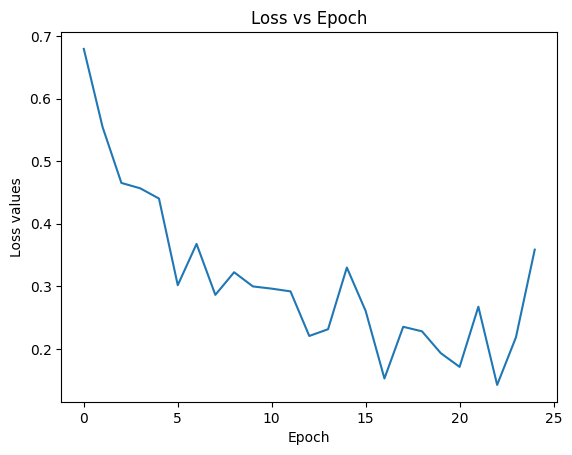

In [45]:
# Training Loss over each iteration
plt.plot(train_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss values')
plt.title('Loss vs Epoch')
plt.show()

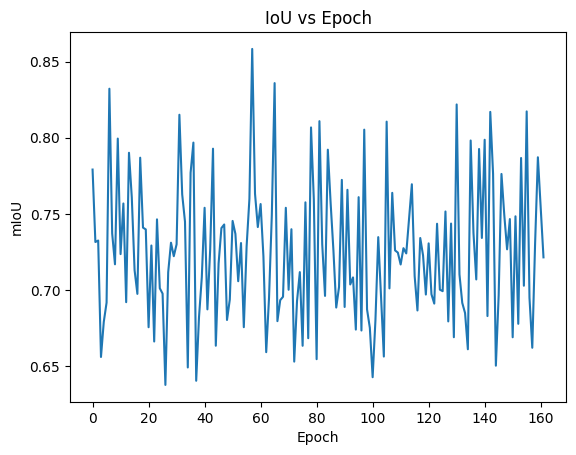

In [46]:


# mIoU for training data over each epoch
plt.plot(avg_iou_train)
plt.xlabel('Epoch')
plt.ylabel('mIoU')
plt.title('IoU vs Epoch')
plt.show()



#### The above graph should have been titled IoU vs Iteration*.  Apologies for typo

## Evaluating the Test Data

In [85]:
print('\n---------Evaluation Metrics for Testing--------\n')
print('Testing IoU')
avg_iou_test=[]
# Test dataset
for input_batch, target_batch in test_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_dl(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_test.append(iou_scores)

print("The testing IoU is: ",np.nanmean(avg_iou_test))


---------Evaluation Metrics for Testing--------

Testing IoU
The testing IoU is:  0.7305192835628986


### Looking at Pixel Accuracy

In [44]:
print('\n---------Evaluation Metrics for Testing--------\n')
print('Testing Accuracy')
avg_acc_test=[]
# Test dataset
for input_batch, target_batch in test_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_dl(input_batch)

  acc_scores = pixel_acc(predict_batch, target_batch)
  avg_acc_test.append(acc_scores)

print("The testing accuracy is: ",np.mean(avg_acc_test))


---------Evaluation Metrics for Testing--------

Testing Accuracy
The testing accuracy is:  0.9242138332790799


## Visualizing some predictions from test data and comparing with target

In [93]:
input_batch, target_batch = next(iter(test_loader))

In [94]:
predict_batch = model_dl(input_batch.to(device))

In [100]:
preds = np.argmax(predict_batch.detach().cpu().numpy(), axis=1)

In [110]:
labels = target_batch.cpu().numpy()

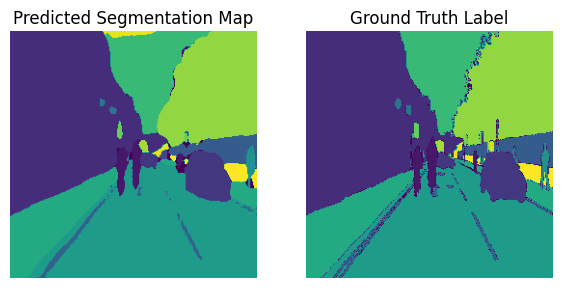

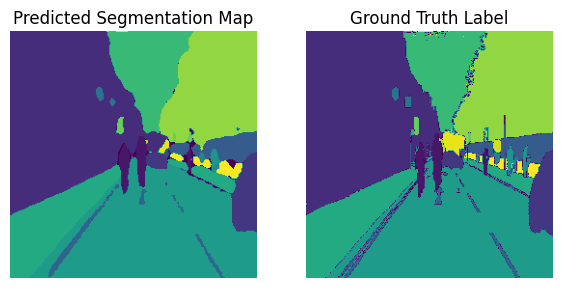

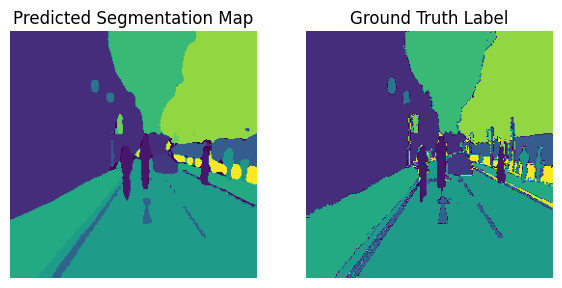

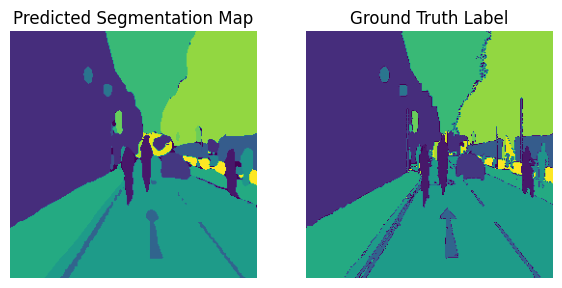

In [115]:
for i in range(4):  
    plt.figure(figsize=(7, 7))
    plt.subplot(121)
    plt.imshow(preds[i])
    plt.axis("off")
    plt.title("Predicted Segmentation Map")
    plt.subplot(122)
    plt.imshow(labels[i])
    plt.axis("off")
    plt.title("Ground Truth Label")
    plt.show()

# Model 2: UNet

## Base Model: Unet.
## Adam, LR=0.001, cross entropy

In [32]:
model_unet = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=32
).to(device)


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 158MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_unet.parameters(), lr=0.001)

In [ ]:
num_epochs=10
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_unet(inputs)
        loss = criterion(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

        train_loss.append(loss.item())

        # scheduler.step()

    #     for input_batch, target_batch in train_loader:

    #       input_batch=input_batch.to(device)
    #       target_batch=target_batch.to(device)

    #       predict_batch = model_dl(input_batch)

    #       iou_scores = iou(predict_batch, target_batch)
    #       avg_iou_train.append(iou_scores)

    # if (epoch+1)%5==0:
    #   print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')

Epoch number 1
Loss after mini-batch   100: 1.365
time taken for epoch 1 is 331.01
Epoch number 2
Loss after mini-batch   100: 0.900
time taken for epoch 2 is 63.57
Epoch number 3
Loss after mini-batch   100: 0.725
time taken for epoch 3 is 63.29
Epoch number 4
Loss after mini-batch   100: 0.656
time taken for epoch 4 is 64.59
Epoch number 5
Loss after mini-batch   100: 0.638
time taken for epoch 5 is 63.81
Epoch number 6
Loss after mini-batch   100: 0.530
time taken for epoch 6 is 64.03
Epoch number 7
Loss after mini-batch   100: 0.539
time taken for epoch 7 is 64.35
Epoch number 8
Loss after mini-batch   100: 0.507
time taken for epoch 8 is 63.25
Epoch number 9
Loss after mini-batch   100: 0.470
time taken for epoch 9 is 64.29
Epoch number 10
Loss after mini-batch   100: 0.442
time taken for epoch 10 is 62.88
Training process has finished. Time taken is 905.07


In [ ]:
# sets the model in evaluation mode 
model_unet.eval()

print('---------Evaluation Metrics for Training--------\n')
print('Training IoU & Accuracy')
avg_iou_train=[]
# Train dataset

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_unet(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU & Accuracy')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_unet(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))


---------Evaluation Metrics for Training--------

Training IoU & Accuracy
The training IoU is:  0.6335270037459332
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU & Accuracy
The validation IoU is:  0.639022475234142


## Learning Rate Tuning


### LR=0.0001

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_unet.parameters(), lr=0.0001)

In [ ]:
num_epochs=10
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_unet(inputs)
        loss = criterion(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

        train_loss.append(loss.item())

        # scheduler.step()

    #     for input_batch, target_batch in train_loader:

    #       input_batch=input_batch.to(device)
    #       target_batch=target_batch.to(device)

    #       predict_batch = model_dl(input_batch)

    #       iou_scores = iou(predict_batch, target_batch)
    #       avg_iou_train.append(iou_scores)

    # if (epoch+1)%5==0:
    #   print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')

Epoch number 1
Loss after mini-batch   100: 0.417
time taken for epoch 1 is 75.07
Epoch number 2
Loss after mini-batch   100: 0.345
time taken for epoch 2 is 62.58
Epoch number 3
Loss after mini-batch   100: 0.358
time taken for epoch 3 is 63.71
Epoch number 4
Loss after mini-batch   100: 0.359
time taken for epoch 4 is 63.56
Epoch number 5
Loss after mini-batch   100: 0.323
time taken for epoch 5 is 65.17
Epoch number 6
Loss after mini-batch   100: 0.332
time taken for epoch 6 is 63.87
Epoch number 7
Loss after mini-batch   100: 0.324
time taken for epoch 7 is 64.52
Epoch number 8
Loss after mini-batch   100: 0.332
time taken for epoch 8 is 64.67
Epoch number 9
Loss after mini-batch   100: 0.347
time taken for epoch 9 is 63.68
Epoch number 10
Loss after mini-batch   100: 0.313
time taken for epoch 10 is 64.63
Training process has finished. Time taken is 651.47


In [ ]:
# sets the model in evaluation mode 
model_unet.eval()

print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]
# Train dataset

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_unet(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_unet(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.6770024148037489
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.6785416593628485


### LR=0.0005

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_unet.parameters(), lr=0.0005)

In [ ]:
num_epochs=10
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_unet(inputs)
        loss = criterion(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

        train_loss.append(loss.item())

        # scheduler.step()

    #     for input_batch, target_batch in train_loader:

    #       input_batch=input_batch.to(device)
    #       target_batch=target_batch.to(device)

    #       predict_batch = model_dl(input_batch)

    #       iou_scores = iou(predict_batch, target_batch)
    #       avg_iou_train.append(iou_scores)

    # if (epoch+1)%5==0:
    #   print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')

Epoch number 1
Loss after mini-batch   100: 1.675
time taken for epoch 1 is 216.15
Epoch number 2
Loss after mini-batch   100: 0.836
time taken for epoch 2 is 64.64
Epoch number 3
Loss after mini-batch   100: 0.673
time taken for epoch 3 is 81.35
Epoch number 4
Loss after mini-batch   100: 0.594
time taken for epoch 4 is 72.04
Epoch number 5
Loss after mini-batch   100: 0.505
time taken for epoch 5 is 63.43
Epoch number 6
Loss after mini-batch   100: 0.497
time taken for epoch 6 is 64.93
Epoch number 7
Loss after mini-batch   100: 0.477
time taken for epoch 7 is 63.24
Epoch number 8
Loss after mini-batch   100: 0.462
time taken for epoch 8 is 65.18
Epoch number 9
Loss after mini-batch   100: 0.423
time taken for epoch 9 is 63.71
Epoch number 10
Loss after mini-batch   100: 0.398
time taken for epoch 10 is 63.55
Training process has finished. Time taken is 818.24


In [ ]:
# sets the model in evaluation mode 
model_unet.eval()

print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]
# Train dataset

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_unet(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_unet(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.6766338879174053
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.6822166164585411


### LR=0.001

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_unet.parameters(), lr=0.001)

In [ ]:
num_epochs=10
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_unet(inputs)
        loss = criterion(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

        train_loss.append(loss.item())

        # scheduler.step()

    #     for input_batch, target_batch in train_loader:

    #       input_batch=input_batch.to(device)
    #       target_batch=target_batch.to(device)

    #       predict_batch = model_dl(input_batch)

    #       iou_scores = iou(predict_batch, target_batch)
    #       avg_iou_train.append(iou_scores)

    # if (epoch+1)%5==0:
    #   print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')

Epoch number 1
Loss after mini-batch   100: 2.076
time taken for epoch 1 is 63.13
Epoch number 2
Loss after mini-batch   100: 0.743
time taken for epoch 2 is 62.94
Epoch number 3
Loss after mini-batch   100: 0.683
time taken for epoch 3 is 63.12
Epoch number 4
Loss after mini-batch   100: 0.604
time taken for epoch 4 is 62.58
Epoch number 5
Loss after mini-batch   100: 0.518
time taken for epoch 5 is 63.31
Epoch number 6
Loss after mini-batch   100: 0.492
time taken for epoch 6 is 62.73
Epoch number 7
Loss after mini-batch   100: 0.480
time taken for epoch 7 is 63.78
Epoch number 8
Loss after mini-batch   100: 0.440
time taken for epoch 8 is 62.44
Epoch number 9
Loss after mini-batch   100: 0.421
time taken for epoch 9 is 63.52
Epoch number 10
Loss after mini-batch   100: 0.422
time taken for epoch 10 is 63.25
Training process has finished. Time taken is 630.80


In [ ]:
# sets the model in evaluation mode 
model_unet.eval()

print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]
# Train dataset

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_unet(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_unet(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.6688181071625197
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.6757625514109853


### LR=0.005

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_unet.parameters(), lr=0.005)

In [ ]:
num_epochs=10
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_unet(inputs)
        loss = criterion(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

        train_loss.append(loss.item())

        # scheduler.step()

    #     for input_batch, target_batch in train_loader:

    #       input_batch=input_batch.to(device)
    #       target_batch=target_batch.to(device)

    #       predict_batch = model_dl(input_batch)

    #       iou_scores = iou(predict_batch, target_batch)
    #       avg_iou_train.append(iou_scores)

    # if (epoch+1)%5==0:
    #   print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')

Epoch number 1
Loss after mini-batch   100: 5.744
time taken for epoch 1 is 68.78
Epoch number 2
Loss after mini-batch   100: 1.606
time taken for epoch 2 is 66.26
Epoch number 3
Loss after mini-batch   100: 1.364
time taken for epoch 3 is 65.11
Epoch number 4
Loss after mini-batch   100: 1.207
time taken for epoch 4 is 63.20
Epoch number 5
Loss after mini-batch   100: 1.217
time taken for epoch 5 is 61.98
Epoch number 6
Loss after mini-batch   100: 1.159
time taken for epoch 6 is 63.21
Epoch number 7
Loss after mini-batch   100: 1.053
time taken for epoch 7 is 62.43
Epoch number 8
Loss after mini-batch   100: 1.086
time taken for epoch 8 is 69.87
Epoch number 9
Loss after mini-batch   100: 1.022
time taken for epoch 9 is 83.03
Epoch number 10
Loss after mini-batch   100: 1.002
time taken for epoch 10 is 64.61
Training process has finished. Time taken is 668.48


In [ ]:
# sets the model in evaluation mode 
model_unet.eval()

print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]
# Train dataset

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_unet(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_unet(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.5222122599683402
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.5369260226065393


## Optimizer

### SGD

In [ ]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model_unet.parameters(), lr=0.001, weight_decay=0.001)
optimizer = optim.SGD(model_unet.parameters(), lr=0.0005, momentum=0.9)
# , weight_decay=0.0001

In [ ]:
num_epochs=10
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_unet(inputs)
        loss = criterion(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

        train_loss.append(loss.item())

        # scheduler.step()

    #     for input_batch, target_batch in train_loader:

    #       input_batch=input_batch.to(device)
    #       target_batch=target_batch.to(device)

    #       predict_batch = model_dl(input_batch)

    #       iou_scores = iou(predict_batch, target_batch)
    #       avg_iou_train.append(iou_scores)

    # if (epoch+1)%5==0:
    #   print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')

Epoch number 1
Loss after mini-batch   100: 0.880
time taken for epoch 1 is 82.03
Epoch number 2
Loss after mini-batch   100: 0.862
time taken for epoch 2 is 85.66
Epoch number 3
Loss after mini-batch   100: 0.882
time taken for epoch 3 is 75.26
Epoch number 4
Loss after mini-batch   100: 0.872
time taken for epoch 4 is 65.75
Epoch number 5
Loss after mini-batch   100: 0.877
time taken for epoch 5 is 61.54
Epoch number 6
Loss after mini-batch   100: 0.873
time taken for epoch 6 is 61.61
Epoch number 7
Loss after mini-batch   100: 0.855
time taken for epoch 7 is 61.73
Epoch number 8
Loss after mini-batch   100: 0.865
time taken for epoch 8 is 60.96
Epoch number 9
Loss after mini-batch   100: 0.830
time taken for epoch 9 is 61.85
Epoch number 10
Loss after mini-batch   100: 0.834
time taken for epoch 10 is 60.95
Training process has finished. Time taken is 677.35


In [ ]:
# sets the model in evaluation mode 
model_unet.eval()

print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]
# Train dataset

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_unet(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_unet(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.5314710049398302
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.5438654319681319


## RMSProp

In [ ]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model_unet.parameters(), lr=0.001, weight_decay=0.001)
# optimizer = optim.SGD(model_unet.parameters(), lr=0.0005, momentum=0.9)
# , weight_decay=0.0001
optimizer = optim.RMSprop(model_unet.parameters(), lr=0.0005)

In [ ]:
num_epochs=10
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_unet(inputs)
        loss = criterion(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

        train_loss.append(loss.item())

        # scheduler.step()

    #     for input_batch, target_batch in train_loader:

    #       input_batch=input_batch.to(device)
    #       target_batch=target_batch.to(device)

    #       predict_batch = model_dl(input_batch)

    #       iou_scores = iou(predict_batch, target_batch)
    #       avg_iou_train.append(iou_scores)

    # if (epoch+1)%5==0:
    #   print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')

Epoch number 1
Loss after mini-batch   100: 0.965
time taken for epoch 1 is 64.44
Epoch number 2
Loss after mini-batch   100: 0.807
time taken for epoch 2 is 62.25
Epoch number 3
Loss after mini-batch   100: 0.822
time taken for epoch 3 is 63.53
Epoch number 4
Loss after mini-batch   100: 0.812
time taken for epoch 4 is 62.92
Epoch number 5
Loss after mini-batch   100: 0.808
time taken for epoch 5 is 63.72
Epoch number 6
Loss after mini-batch   100: 0.807
time taken for epoch 6 is 64.15
Epoch number 7
Loss after mini-batch   100: 0.789
time taken for epoch 7 is 65.39
Epoch number 8
Loss after mini-batch   100: 0.809
time taken for epoch 8 is 64.39
Epoch number 9
Loss after mini-batch   100: 0.763
time taken for epoch 9 is 64.57
Epoch number 10
Loss after mini-batch   100: 0.777
time taken for epoch 10 is 65.64
Training process has finished. Time taken is 640.99


In [ ]:
# sets the model in evaluation mode 
model_unet.eval()

print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]
# Train dataset

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_unet(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_unet(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.5457059498681263
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.5604340975071765


## Adam

In [36]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_unet.parameters(), lr=0.0005)
# optimizer = optim.SGD(model_unet.parameters(), lr=0.0005, momentum=0.9)
# , weight_decay=0.0001
# optimizer = optim.RMSprop(model_unet.parameters(), lr=0.0005)

In [37]:
num_epochs=10
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_unet(inputs)
        loss = criterion(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

        train_loss.append(loss.item())

        # scheduler.step()

    #     for input_batch, target_batch in train_loader:

    #       input_batch=input_batch.to(device)
    #       target_batch=target_batch.to(device)

    #       predict_batch = model_dl(input_batch)

    #       iou_scores = iou(predict_batch, target_batch)
    #       avg_iou_train.append(iou_scores)

    # if (epoch+1)%5==0:
    #   print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')

Epoch number 1
Loss after mini-batch   100: 1.777
time taken for epoch 1 is 72.46
Epoch number 2
Loss after mini-batch   100: 0.805
time taken for epoch 2 is 63.49
Epoch number 3
Loss after mini-batch   100: 0.672
time taken for epoch 3 is 64.42
Epoch number 4
Loss after mini-batch   100: 0.560
time taken for epoch 4 is 63.30
Epoch number 5
Loss after mini-batch   100: 0.495
time taken for epoch 5 is 63.69
Epoch number 6
Loss after mini-batch   100: 0.476
time taken for epoch 6 is 64.08
Epoch number 7
Loss after mini-batch   100: 0.444
time taken for epoch 7 is 62.93
Epoch number 8
Loss after mini-batch   100: 0.483
time taken for epoch 8 is 64.10
Epoch number 9
Loss after mini-batch   100: 0.391
time taken for epoch 9 is 63.30
Epoch number 10
Loss after mini-batch   100: 0.431
time taken for epoch 10 is 63.97
Training process has finished. Time taken is 645.76


In [38]:
# sets the model in evaluation mode 
model_unet.eval()

print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]
# Train dataset

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_unet(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_unet(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.6689188509076753
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.6617358911160811


## Scheduler: Yes. StepLR- gamma=0.10


In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_unet.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.10)

In [40]:
num_epochs=5
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_unet(inputs)
        loss = criterion(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

        train_loss.append(loss.item())

        scheduler.step()

    #     for input_batch, target_batch in train_loader:

    #       input_batch=input_batch.to(device)
    #       target_batch=target_batch.to(device)

    #       predict_batch = model_dl(input_batch)

    #       iou_scores = iou(predict_batch, target_batch)
    #       avg_iou_train.append(iou_scores)

    # if (epoch+1)%5==0:
    #   print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')

Epoch number 1
Loss after mini-batch   100: 0.595
time taken for epoch 1 is 77.68
Epoch number 2
Loss after mini-batch   100: 0.577
time taken for epoch 2 is 64.92
Epoch number 3
Loss after mini-batch   100: 0.565
time taken for epoch 3 is 65.71
Epoch number 4
Loss after mini-batch   100: 0.567
time taken for epoch 4 is 63.69
Epoch number 5
Loss after mini-batch   100: 0.540
time taken for epoch 5 is 64.59
Training process has finished. Time taken is 336.60


In [41]:
# sets the model in evaluation mode 
model_unet.eval()

print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]
# Train dataset

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_unet(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_unet(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.6154606350949727
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.6215934022434639


## Scheduler: Yes. StepLR- gamma=0.15


In [42]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_unet.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.15)

In [43]:
num_epochs=5
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_unet(inputs)
        loss = criterion(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

        train_loss.append(loss.item())

        scheduler.step()

    #     for input_batch, target_batch in train_loader:

    #       input_batch=input_batch.to(device)
    #       target_batch=target_batch.to(device)

    #       predict_batch = model_dl(input_batch)

    #       iou_scores = iou(predict_batch, target_batch)
    #       avg_iou_train.append(iou_scores)

    # if (epoch+1)%5==0:
    #   print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')

Epoch number 1
Loss after mini-batch   100: 0.954
time taken for epoch 1 is 69.99
Epoch number 2
Loss after mini-batch   100: 0.891
time taken for epoch 2 is 64.59
Epoch number 3
Loss after mini-batch   100: 0.894
time taken for epoch 3 is 63.82
Epoch number 4
Loss after mini-batch   100: 0.896
time taken for epoch 4 is 64.82
Epoch number 5
Loss after mini-batch   100: 0.905
time taken for epoch 5 is 63.65
Training process has finished. Time taken is 326.88


In [44]:
# sets the model in evaluation mode 
model_unet.eval()

print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]
# Train dataset

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_unet(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_unet(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.5403597164020871
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.5417909606044284


## Scheduler: Yes. ReduceLR on Plateau


In [45]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_unet.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [47]:
num_epochs=5
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_unet(inputs)
        loss = criterion(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

        train_loss.append(loss.item())

        scheduler.step(current_loss)

    #     for input_batch, target_batch in train_loader:

    #       input_batch=input_batch.to(device)
    #       target_batch=target_batch.to(device)

    #       predict_batch = model_dl(input_batch)

    #       iou_scores = iou(predict_batch, target_batch)
    #       avg_iou_train.append(iou_scores)

    # if (epoch+1)%5==0:
    #   print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')

Epoch number 1
Loss after mini-batch   100: 0.981
time taken for epoch 1 is 77.51
Epoch number 2
Loss after mini-batch   100: 0.955
time taken for epoch 2 is 64.55
Epoch number 3
Loss after mini-batch   100: 0.938
time taken for epoch 3 is 63.70
Epoch number 4
Loss after mini-batch   100: 0.952
time taken for epoch 4 is 63.84
Epoch number 5
Loss after mini-batch   100: 0.993
time taken for epoch 5 is 64.16
Training process has finished. Time taken is 333.77


In [48]:
# sets the model in evaluation mode 
model_unet.eval()

print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]
# Train dataset

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_unet(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_unet(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.5410688741364023
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.5428937147811135


## Scheduler: No


In [52]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_unet.parameters(), lr=0.0005)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [54]:
num_epochs=5
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_unet(inputs)
        loss = criterion(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

        train_loss.append(loss.item())

        # scheduler.step()

    #     for input_batch, target_batch in train_loader:

    #       input_batch=input_batch.to(device)
    #       target_batch=target_batch.to(device)

    #       predict_batch = model_dl(input_batch)

    #       iou_scores = iou(predict_batch, target_batch)
    #       avg_iou_train.append(iou_scores)

    # if (epoch+1)%5==0:
    #   print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')

Epoch number 1
Loss after mini-batch   100: 0.392
time taken for epoch 1 is 70.44
Epoch number 2
Loss after mini-batch   100: 0.397
time taken for epoch 2 is 64.35
Epoch number 3
Loss after mini-batch   100: 0.347
time taken for epoch 3 is 63.91
Epoch number 4
Loss after mini-batch   100: 0.395
time taken for epoch 4 is 62.81
Epoch number 5
Loss after mini-batch   100: 0.401
time taken for epoch 5 is 63.78
Training process has finished. Time taken is 325.30


In [55]:
# sets the model in evaluation mode 
model_unet.eval()

print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]
# Train dataset

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_unet(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_unet(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.6826900754011348
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.6761493837373977


## Weight Decay = 0.0001


In [56]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_unet.parameters(), lr=0.0005, weight_decay=0.0001)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [57]:
num_epochs=5
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_unet(inputs)
        loss = criterion(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

        train_loss.append(loss.item())

        # scheduler.step()

    #     for input_batch, target_batch in train_loader:

    #       input_batch=input_batch.to(device)
    #       target_batch=target_batch.to(device)

    #       predict_batch = model_dl(input_batch)

    #       iou_scores = iou(predict_batch, target_batch)
    #       avg_iou_train.append(iou_scores)

    # if (epoch+1)%5==0:
    #   print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')

Epoch number 1
Loss after mini-batch   100: 0.357
time taken for epoch 1 is 91.36
Epoch number 2
Loss after mini-batch   100: 0.381
time taken for epoch 2 is 67.60
Epoch number 3
Loss after mini-batch   100: 0.312
time taken for epoch 3 is 63.83
Epoch number 4
Loss after mini-batch   100: 0.286
time taken for epoch 4 is 62.71
Epoch number 5
Loss after mini-batch   100: 0.387
time taken for epoch 5 is 63.70
Training process has finished. Time taken is 349.20


In [58]:
# sets the model in evaluation mode 
model_unet.eval()

print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]
# Train dataset

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_unet(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_unet(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.702602587983148
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.6953138456970751


## Weight Decay = 0.0005


In [59]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_unet.parameters(), lr=0.0005, weight_decay=0.0005)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [60]:
num_epochs=5
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_unet(inputs)
        loss = criterion(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

        train_loss.append(loss.item())

        # scheduler.step()

    #     for input_batch, target_batch in train_loader:

    #       input_batch=input_batch.to(device)
    #       target_batch=target_batch.to(device)

    #       predict_batch = model_dl(input_batch)

    #       iou_scores = iou(predict_batch, target_batch)
    #       avg_iou_train.append(iou_scores)

    # if (epoch+1)%5==0:
    #   print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')

Epoch number 1
Loss after mini-batch   100: 0.323
time taken for epoch 1 is 63.58
Epoch number 2
Loss after mini-batch   100: 0.327
time taken for epoch 2 is 63.01
Epoch number 3
Loss after mini-batch   100: 0.302
time taken for epoch 3 is 63.21
Epoch number 4
Loss after mini-batch   100: 0.322
time taken for epoch 4 is 63.49
Epoch number 5
Loss after mini-batch   100: 0.288
time taken for epoch 5 is 62.73
Training process has finished. Time taken is 316.02


In [61]:
# sets the model in evaluation mode 
model_unet.eval()

print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]
# Train dataset

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_unet(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_unet(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.690944135783324
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.6804048506133473


## Weight Decay = 0


In [62]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_unet.parameters(), lr=0.0005)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [63]:
num_epochs=5
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_unet(inputs)
        loss = criterion(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

        train_loss.append(loss.item())

        # scheduler.step()

    #     for input_batch, target_batch in train_loader:

    #       input_batch=input_batch.to(device)
    #       target_batch=target_batch.to(device)

    #       predict_batch = model_dl(input_batch)

    #       iou_scores = iou(predict_batch, target_batch)
    #       avg_iou_train.append(iou_scores)

    # if (epoch+1)%5==0:
    #   print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')

Epoch number 1
Loss after mini-batch   100: 0.328
time taken for epoch 1 is 62.75
Epoch number 2
Loss after mini-batch   100: 0.287
time taken for epoch 2 is 62.90
Epoch number 3
Loss after mini-batch   100: 0.352
time taken for epoch 3 is 62.66
Epoch number 4
Loss after mini-batch   100: 0.254
time taken for epoch 4 is 62.79
Epoch number 5
Loss after mini-batch   100: 0.297
time taken for epoch 5 is 62.65
Training process has finished. Time taken is 313.76


In [64]:
# sets the model in evaluation mode 
model_unet.eval()

print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]
# Train dataset

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_unet(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_unet(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.6972642252076872
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.6899190724300144


## Dice Loss: Function is defined above

In [ ]:
optimizer = optim.Adam(model_unet.parameters(), lr=0.0005, weight_decay=0.0001)

In [67]:
num_epochs=5
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_unet(inputs)
        loss = dice_loss_multi_class(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

        train_loss.append(loss.item())

        # scheduler.step()

    #     for input_batch, target_batch in train_loader:

    #       input_batch=input_batch.to(device)
    #       target_batch=target_batch.to(device)

    #       predict_batch = model_dl(input_batch)

    #       iou_scores = iou(predict_batch, target_batch)
    #       avg_iou_train.append(iou_scores)

    # if (epoch+1)%5==0:
    #   print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')

Epoch number 1
Loss after mini-batch   100: 0.991
time taken for epoch 1 is 93.59
Epoch number 2
Loss after mini-batch   100: 0.937
time taken for epoch 2 is 77.57
Epoch number 3
Loss after mini-batch   100: 0.937
time taken for epoch 3 is 67.62
Epoch number 4
Loss after mini-batch   100: 0.936
time taken for epoch 4 is 68.07
Epoch number 5
Loss after mini-batch   100: 0.937
time taken for epoch 5 is 68.03
Training process has finished. Time taken is 374.89


In [68]:
# sets the model in evaluation mode 
model_unet.eval()

print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]
# Train dataset

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_unet(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_unet(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.43775327190631713
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.4377531803652312


## CE Loss

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_unet.parameters(), lr=0.0005, weight_decay=0.0001)

In [34]:
num_epochs=5
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_unet(inputs)
        loss = criterion(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

        train_loss.append(loss.item())

        # scheduler.step()

    #     for input_batch, target_batch in train_loader:

    #       input_batch=input_batch.to(device)
    #       target_batch=target_batch.to(device)

    #       predict_batch = model_dl(input_batch)

    #       iou_scores = iou(predict_batch, target_batch)
    #       avg_iou_train.append(iou_scores)

    # if (epoch+1)%5==0:
    #   print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')

Epoch number 1
Loss after mini-batch   100: 1.660
time taken for epoch 1 is 600.70
Epoch number 2
Loss after mini-batch   100: 0.786
time taken for epoch 2 is 62.39
Epoch number 3
Loss after mini-batch   100: 0.748
time taken for epoch 3 is 61.52
Epoch number 4
Loss after mini-batch   100: 0.573
time taken for epoch 4 is 62.56
Epoch number 5
Loss after mini-batch   100: 0.528
time taken for epoch 5 is 62.08
Training process has finished. Time taken is 849.25


In [35]:
# sets the model in evaluation mode 
model_unet.eval()

print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]
# Train dataset

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_unet(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_unet(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.6390065413454089
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.6482402772067383


## Best Model for UNet

In [36]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_unet.parameters(), lr=0.0005, weight_decay=0.0001)

In [38]:
num_epochs=25
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_unet(inputs)
        loss = criterion(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

    train_loss.append(loss.item())

    # scheduler.step()

    for input_batch, target_batch in train_loader:

      input_batch=input_batch.to(device)
      target_batch=target_batch.to(device)

      predict_batch = model_unet(input_batch)

      iou_scores = iou(predict_batch, target_batch)
      avg_iou_train.append(iou_scores)

    if (epoch+1)%5==0:
      print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'Time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')

Epoch number 1
Loss after mini-batch   100: 0.601
Time taken for epoch 1 is 133.43
Epoch number 2
Loss after mini-batch   100: 0.435
Time taken for epoch 2 is 119.02
Epoch number 3
Loss after mini-batch   100: 0.473
Time taken for epoch 3 is 119.49
Epoch number 4
Loss after mini-batch   100: 0.421
Time taken for epoch 4 is 119.85
Epoch number 5
Loss after mini-batch   100: 0.452
mIoU for training dataset after epoch 5 is 0.62
Time taken for epoch 5 is 118.90
Epoch number 6
Loss after mini-batch   100: 0.435
Time taken for epoch 6 is 119.55
Epoch number 7
Loss after mini-batch   100: 0.492
Time taken for epoch 7 is 119.99
Epoch number 8
Loss after mini-batch   100: 0.413
Time taken for epoch 8 is 118.94
Epoch number 9
Loss after mini-batch   100: 0.395
Time taken for epoch 9 is 119.53
Epoch number 10
Loss after mini-batch   100: 0.306
mIoU for training dataset after epoch 10 is 0.64
Time taken for epoch 10 is 119.65
Epoch number 11
Loss after mini-batch   100: 0.309
Time taken for epoch

In [39]:
# sets the model in evaluation mode 
model_unet.eval()

print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]
# Train dataset

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_unet(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:  

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_unet(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.6635309895600061
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.666104099014118


## Visualizing the training loss and mIoU

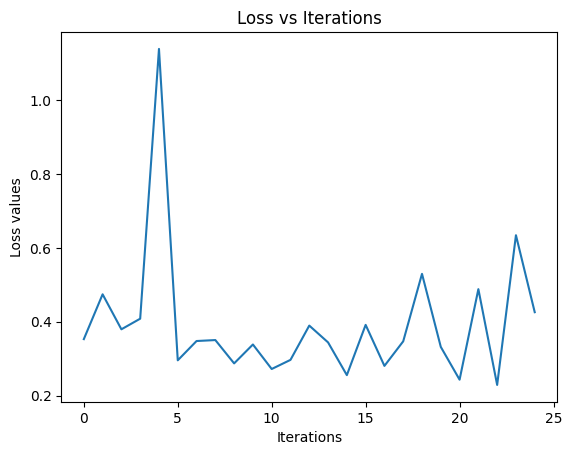

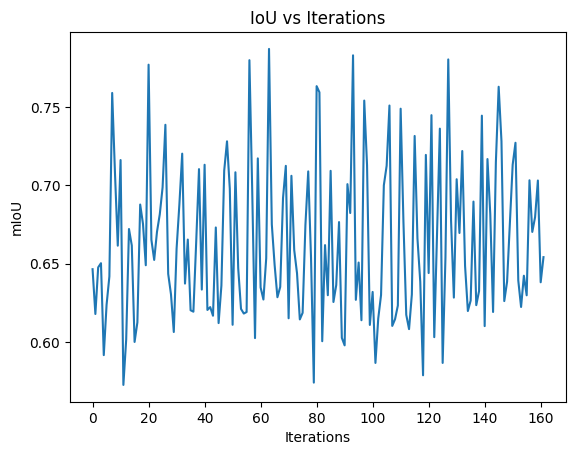

In [40]:
# Training Loss over each iteration
plt.plot(train_loss)
plt.xlabel('Iterations')
plt.ylabel('Loss values')
plt.title('Loss vs Iterations')
plt.show()

# mIoU for training data over each epoch
plt.plot(avg_iou_train)
plt.xlabel('Iterations')
plt.ylabel('mIoU')
plt.title('IoU vs Iterations')
plt.show()

## Evaluating the Test Data



In [41]:
print('\n---------Evaluation Metrics for Testing--------\n')
print('Testing IoU')
avg_iou_test=[]
# Test dataset
for input_batch, target_batch in test_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_unet(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_test.append(iou_scores)

print("The testing IoU is: ",np.nanmean(avg_iou_test))



---------Evaluation Metrics for Testing--------

Testing IoU
The testing IoU is:  0.6227675528447433


## Looking at Pixel Accuracy

In [71]:
print('\n---------Evaluation Metrics for Testing--------\n')
print('Testing Accuracy')
avg_acc_test=[]
# Test dataset
for input_batch, target_batch in test_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_unet(input_batch)

  acc_scores = pixel_acc(predict_batch, target_batch)
  avg_acc_test.append(acc_scores)

print("The testing accuracy is: ",np.mean(avg_acc_test))


---------Evaluation Metrics for Testing--------

Testing Accuracy
The testing accuracy is:  0.9102456834581164


## Visualizing some predictions from test data and comparing with target

In [44]:
input_batch, target_batch = next(iter(test_loader))
predict_batch = model_unet(input_batch.to(device))
preds = np.argmax(predict_batch.detach().cpu().numpy(), axis=1)
labels = target_batch.cpu().numpy()

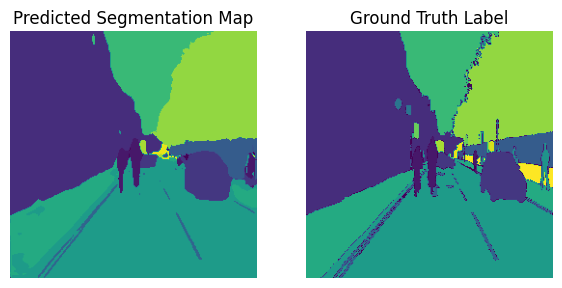

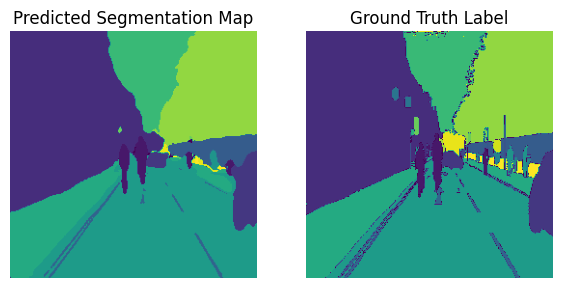

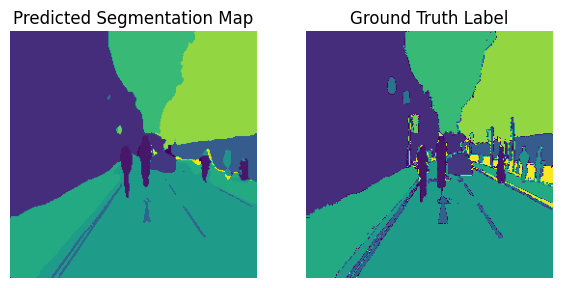

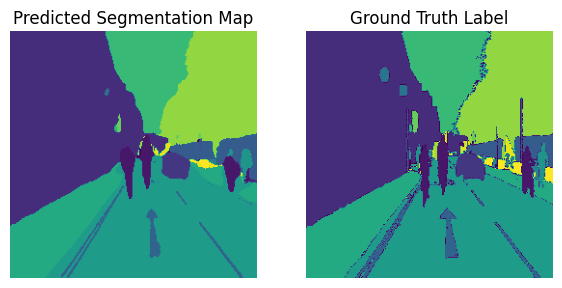

In [45]:
for i in range(4):  
    plt.figure(figsize=(7, 7))
    plt.subplot(121)
    plt.imshow(preds[i])
    plt.axis("off")
    plt.title("Predicted Segmentation Map")
    plt.subplot(122)
    plt.imshow(labels[i])
    plt.axis("off")
    plt.title("Ground Truth Label")
    plt.show()


## Final Model - PSPNet
### Base Model: LR=0.001, opt=Adam, criterion=CE Loss

In [40]:
model_psp = smp.PSPNet(
                    encoder_name="resnet50",
                    encoder_weights='imagenet',
                    in_channels=3,
                    classes=32).to(device)

In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_psp.parameters(), lr=0.001)

In [42]:
num_epochs=5
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_psp(inputs)
        loss = criterion(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

    train_loss.append(loss.item())

    # scheduler.step()

#   for input_batch, target_batch in train_loader:

#     input_batch=input_batch.to(device)
#     target_batch=target_batch.to(device)

#     predict_batch = model_psp(input_batch)

#     iou_scores = iou(predict_batch, target_batch)
#     avg_iou_train.append(iou_scores)

  # if (epoch+1)%5==0:
  #   print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')

Epoch number 1
Loss after mini-batch   100: 0.968
time taken for epoch 1 is 1057.44
Epoch number 2
Loss after mini-batch   100: 0.671
time taken for epoch 2 is 57.34
Epoch number 3
Loss after mini-batch   100: 0.584
time taken for epoch 3 is 57.59
Epoch number 4
Loss after mini-batch   100: 0.509
time taken for epoch 4 is 59.02
Epoch number 5
Loss after mini-batch   100: 0.591
time taken for epoch 5 is 59.07
Training process has finished. Time taken is 1290.46


In [44]:
# sets the model in evaluation mode 
model_psp.eval()

print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]
# Train dataset

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_psp(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_psp(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.5998650565796618
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.5956119141259789


# Tuning Learning Rate

## LR = 0.0001

In [45]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_psp.parameters(), lr=0.0001)

In [46]:
num_epochs=5
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_psp(inputs)
        loss = criterion(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

    train_loss.append(loss.item())

    # scheduler.step()

#   for input_batch, target_batch in train_loader:

#     input_batch=input_batch.to(device)
#     target_batch=target_batch.to(device)

#     predict_batch = model_psp(input_batch)

#     iou_scores = iou(predict_batch, target_batch)
#     avg_iou_train.append(iou_scores)

  # if (epoch+1)%5==0:
  #   print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')

Epoch number 1
Loss after mini-batch   100: 0.399
time taken for epoch 1 is 63.49
Epoch number 2
Loss after mini-batch   100: 0.347
time taken for epoch 2 is 57.53
Epoch number 3
Loss after mini-batch   100: 0.317
time taken for epoch 3 is 57.83
Epoch number 4
Loss after mini-batch   100: 0.325
time taken for epoch 4 is 57.10
Epoch number 5
Loss after mini-batch   100: 0.292
time taken for epoch 5 is 57.60
Training process has finished. Time taken is 293.57


In [47]:
# sets the model in evaluation mode 
model_psp.eval()

print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]
# Train dataset

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_psp(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_psp(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.7029521295716089
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.6906782476491933


## LR = 0.0005

In [48]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_psp.parameters(), lr=0.0005)

In [49]:
num_epochs=5
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_psp(inputs)
        loss = criterion(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

    train_loss.append(loss.item())

    # scheduler.step()

#   for input_batch, target_batch in train_loader:

#     input_batch=input_batch.to(device)
#     target_batch=target_batch.to(device)

#     predict_batch = model_psp(input_batch)

#     iou_scores = iou(predict_batch, target_batch)
#     avg_iou_train.append(iou_scores)

  # if (epoch+1)%5==0:
  #   print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')

Epoch number 1
Loss after mini-batch   100: 0.415
time taken for epoch 1 is 57.34
Epoch number 2
Loss after mini-batch   100: 0.568
time taken for epoch 2 is 57.01
Epoch number 3
Loss after mini-batch   100: 0.345
time taken for epoch 3 is 56.95
Epoch number 4
Loss after mini-batch   100: 0.307
time taken for epoch 4 is 56.92
Epoch number 5
Loss after mini-batch   100: 0.382
time taken for epoch 5 is 57.26
Training process has finished. Time taken is 285.50


In [50]:
# sets the model in evaluation mode 
model_psp.eval()

print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]
# Train dataset

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_psp(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_psp(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.7038334261532361
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.6908034455951161


## LR = 0.001

In [51]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_psp.parameters(), lr=0.001)

In [52]:
num_epochs=5
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_psp(inputs)
        loss = criterion(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

    train_loss.append(loss.item())

    # scheduler.step()

#   for input_batch, target_batch in train_loader:

#     input_batch=input_batch.to(device)
#     target_batch=target_batch.to(device)

#     predict_batch = model_psp(input_batch)

#     iou_scores = iou(predict_batch, target_batch)
#     avg_iou_train.append(iou_scores)

  # if (epoch+1)%5==0:
  #   print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')

Epoch number 1
Loss after mini-batch   100: 0.627
time taken for epoch 1 is 73.15
Epoch number 2
Loss after mini-batch   100: 0.441
time taken for epoch 2 is 78.46
Epoch number 3
Loss after mini-batch   100: 0.405
time taken for epoch 3 is 81.15
Epoch number 4
Loss after mini-batch   100: 0.353
time taken for epoch 4 is 57.39
Epoch number 5
Loss after mini-batch   100: 0.431
time taken for epoch 5 is 57.01
Training process has finished. Time taken is 347.16


In [53]:
# sets the model in evaluation mode 
model_psp.eval()

print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]
# Train dataset

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_psp(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_psp(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.6932478729408869
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.6745216647959111


## LR = 0.005

In [54]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_psp.parameters(), lr=0.005)

In [55]:
num_epochs=5
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_psp(inputs)
        loss = criterion(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

    train_loss.append(loss.item())

    # scheduler.step()

#   for input_batch, target_batch in train_loader:

#     input_batch=input_batch.to(device)
#     target_batch=target_batch.to(device)

#     predict_batch = model_psp(input_batch)

#     iou_scores = iou(predict_batch, target_batch)
#     avg_iou_train.append(iou_scores)

  # if (epoch+1)%5==0:
  #   print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')

Epoch number 1
Loss after mini-batch   100: 1.369
time taken for epoch 1 is 56.78
Epoch number 2
Loss after mini-batch   100: 1.021
time taken for epoch 2 is 56.82
Epoch number 3
Loss after mini-batch   100: 0.749
time taken for epoch 3 is 56.49
Epoch number 4
Loss after mini-batch   100: 0.637
time taken for epoch 4 is 56.56
Epoch number 5
Loss after mini-batch   100: 0.553
time taken for epoch 5 is 56.50
Training process has finished. Time taken is 283.15


In [56]:
# sets the model in evaluation mode 
model_psp.eval()

print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]
# Train dataset

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_psp(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_psp(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.5775133990854386
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.5672333280186953


# Optimizers

## SGD

In [57]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_psp.parameters(), momentum=0.9, lr=0.0005)

In [58]:
num_epochs=5
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_psp(inputs)
        loss = criterion(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

    train_loss.append(loss.item())

    # scheduler.step()

#   for input_batch, target_batch in train_loader:

#     input_batch=input_batch.to(device)
#     target_batch=target_batch.to(device)

#     predict_batch = model_psp(input_batch)

#     iou_scores = iou(predict_batch, target_batch)
#     avg_iou_train.append(iou_scores)

  # if (epoch+1)%5==0:
  #   print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')

Epoch number 1
Loss after mini-batch   100: 0.644
time taken for epoch 1 is 72.58
Epoch number 2
Loss after mini-batch   100: 0.553
time taken for epoch 2 is 57.09
Epoch number 3
Loss after mini-batch   100: 0.508
time taken for epoch 3 is 56.60
Epoch number 4
Loss after mini-batch   100: 0.492
time taken for epoch 4 is 56.22
Epoch number 5
Loss after mini-batch   100: 0.473
time taken for epoch 5 is 56.12
Training process has finished. Time taken is 298.61


In [59]:
# sets the model in evaluation mode 
model_psp.eval()

print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]
# Train dataset

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_psp(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_psp(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.6328550636683563
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.62604885447551


## RMSProp

In [60]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model_psp.parameters(), lr=0.0005)

In [61]:
num_epochs=5
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_psp(inputs)
        loss = criterion(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

    train_loss.append(loss.item())

    # scheduler.step()

#   for input_batch, target_batch in train_loader:

#     input_batch=input_batch.to(device)
#     target_batch=target_batch.to(device)

#     predict_batch = model_psp(input_batch)

#     iou_scores = iou(predict_batch, target_batch)
#     avg_iou_train.append(iou_scores)

  # if (epoch+1)%5==0:
  #   print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')

Epoch number 1
Loss after mini-batch   100: 0.488
time taken for epoch 1 is 56.11
Epoch number 2
Loss after mini-batch   100: 0.406
time taken for epoch 2 is 56.14
Epoch number 3
Loss after mini-batch   100: 0.372
time taken for epoch 3 is 56.02
Epoch number 4
Loss after mini-batch   100: 0.340
time taken for epoch 4 is 56.16
Epoch number 5
Loss after mini-batch   100: 0.328
time taken for epoch 5 is 56.22
Training process has finished. Time taken is 280.65


In [62]:
# sets the model in evaluation mode 
model_psp.eval()

print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]
# Train dataset

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_psp(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_psp(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.6836420767365159
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.6681353821710682


## Adam

In [65]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_psp.parameters(), lr=0.0005)

In [66]:
num_epochs=5
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_psp(inputs)
        loss = criterion(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

    train_loss.append(loss.item())

    # scheduler.step()

#   for input_batch, target_batch in train_loader:

#     input_batch=input_batch.to(device)
#     target_batch=target_batch.to(device)

#     predict_batch = model_psp(input_batch)

#     iou_scores = iou(predict_batch, target_batch)
#     avg_iou_train.append(iou_scores)

  # if (epoch+1)%5==0:
  #   print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')

Epoch number 1
Loss after mini-batch   100: 0.325
time taken for epoch 1 is 68.50
Epoch number 2
Loss after mini-batch   100: 0.322
time taken for epoch 2 is 72.36
Epoch number 3
Loss after mini-batch   100: 0.297
time taken for epoch 3 is 75.88
Epoch number 4
Loss after mini-batch   100: 0.299
time taken for epoch 4 is 64.46
Epoch number 5
Loss after mini-batch   100: 0.292
time taken for epoch 5 is 55.85
Training process has finished. Time taken is 337.05


In [67]:
# sets the model in evaluation mode 
model_psp.eval()

print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]
# Train dataset

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_psp(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_psp(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.7044449416363666
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.6875979573279029


## Scheduler

## Scheduler- Yes StepLR: gamma=0.10

In [68]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_psp.parameters(), lr=0.0005)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.10)

In [70]:
num_epochs=5
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_psp(inputs)
        loss = criterion(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

    train_loss.append(loss.item())

    scheduler.step()

#   for input_batch, target_batch in train_loader:

#     input_batch=input_batch.to(device)
#     target_batch=target_batch.to(device)

#     predict_batch = model_psp(input_batch)

#     iou_scores = iou(predict_batch, target_batch)
#     avg_iou_train.append(iou_scores)

  # if (epoch+1)%5==0:
  #   print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')

Epoch number 1
Loss after mini-batch   100: 0.298
time taken for epoch 1 is 78.94
Epoch number 2
Loss after mini-batch   100: 0.267
time taken for epoch 2 is 74.91
Epoch number 3
Loss after mini-batch   100: 0.253
time taken for epoch 3 is 69.47
Epoch number 4
Loss after mini-batch   100: 0.243
time taken for epoch 4 is 56.36
Epoch number 5
Loss after mini-batch   100: 0.242
time taken for epoch 5 is 56.32
Training process has finished. Time taken is 336.01


In [71]:
# sets the model in evaluation mode 
model_psp.eval()

print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]
# Train dataset

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_psp(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_psp(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.7199486809249618
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.6960852972736028


## Scheduler- Yes StepLR: gamma=0.15

In [72]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_psp.parameters(), lr=0.0005)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.15)

In [73]:
num_epochs=5
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_psp(inputs)
        loss = criterion(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

    train_loss.append(loss.item())

    scheduler.step()

#   for input_batch, target_batch in train_loader:

#     input_batch=input_batch.to(device)
#     target_batch=target_batch.to(device)

#     predict_batch = model_psp(input_batch)

#     iou_scores = iou(predict_batch, target_batch)
#     avg_iou_train.append(iou_scores)

  # if (epoch+1)%5==0:
  #   print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')

Epoch number 1
Loss after mini-batch   100: 0.269
time taken for epoch 1 is 56.71
Epoch number 2
Loss after mini-batch   100: 0.244
time taken for epoch 2 is 57.15
Epoch number 3
Loss after mini-batch   100: 0.274
time taken for epoch 3 is 56.03
Epoch number 4
Loss after mini-batch   100: 0.239
time taken for epoch 4 is 55.83
Epoch number 5
Loss after mini-batch   100: 0.231
time taken for epoch 5 is 55.90
Training process has finished. Time taken is 281.63


In [74]:
# sets the model in evaluation mode 
model_psp.eval()

print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]
# Train dataset

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_psp(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_psp(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.7245101114043329
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.7010951457908114


## Scheduler- Yes ReduceLR on Plateau

In [75]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_psp.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.10)

In [76]:
num_epochs=5
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_psp(inputs)
        loss = criterion(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

    train_loss.append(loss.item())

    scheduler.step(loss.item())

#   for input_batch, target_batch in train_loader:

#     input_batch=input_batch.to(device)
#     target_batch=target_batch.to(device)

#     predict_batch = model_psp(input_batch)

#     iou_scores = iou(predict_batch, target_batch)
#     avg_iou_train.append(iou_scores)

  # if (epoch+1)%5==0:
  #   print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')

Epoch number 1
Loss after mini-batch   100: 0.254
time taken for epoch 1 is 55.81
Epoch number 2
Loss after mini-batch   100: 0.247
time taken for epoch 2 is 55.78
Epoch number 3
Loss after mini-batch   100: 0.229
time taken for epoch 3 is 55.88
Epoch number 4
Loss after mini-batch   100: 0.349
time taken for epoch 4 is 55.81
Epoch number 5
Loss after mini-batch   100: 0.269
time taken for epoch 5 is 55.63
Training process has finished. Time taken is 278.91


In [77]:
# sets the model in evaluation mode 
model_psp.eval()

print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]
# Train dataset

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_psp(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_psp(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.7262377359447718
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.7021653514558781


## Scheduler- No

In [78]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_psp.parameters(), lr=0.0005)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.10)

In [79]:
num_epochs=5
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_psp(inputs)
        loss = criterion(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

    train_loss.append(loss.item())

    # scheduler.step()

#   for input_batch, target_batch in train_loader:

#     input_batch=input_batch.to(device)
#     target_batch=target_batch.to(device)

#     predict_batch = model_psp(input_batch)

#     iou_scores = iou(predict_batch, target_batch)
#     avg_iou_train.append(iou_scores)

  # if (epoch+1)%5==0:
  #   print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')

Epoch number 1
Loss after mini-batch   100: 0.246
time taken for epoch 1 is 56.22
Epoch number 2
Loss after mini-batch   100: 0.235
time taken for epoch 2 is 56.21
Epoch number 3
Loss after mini-batch   100: 0.217
time taken for epoch 3 is 56.08
Epoch number 4
Loss after mini-batch   100: 0.243
time taken for epoch 4 is 55.87
Epoch number 5
Loss after mini-batch   100: 0.215
time taken for epoch 5 is 55.81
Training process has finished. Time taken is 280.19


In [80]:
# sets the model in evaluation mode 
model_psp.eval()

print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]
# Train dataset

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_psp(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_psp(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.7383427622721904
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.7105753036983427


## Weight Decay = 0.0001

In [81]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_psp.parameters(), lr=0.0005, weight_decay=0.0001)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.10)

In [82]:
num_epochs=5
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_psp(inputs)
        loss = criterion(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

    train_loss.append(loss.item())

    # scheduler.step()

#   for input_batch, target_batch in train_loader:

#     input_batch=input_batch.to(device)
#     target_batch=target_batch.to(device)

#     predict_batch = model_psp(input_batch)

#     iou_scores = iou(predict_batch, target_batch)
#     avg_iou_train.append(iou_scores)

  # if (epoch+1)%5==0:
  #   print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')

Epoch number 1
Loss after mini-batch   100: 0.224
time taken for epoch 1 is 82.33
Epoch number 2
Loss after mini-batch   100: 0.229
time taken for epoch 2 is 78.63
Epoch number 3
Loss after mini-batch   100: 0.322
time taken for epoch 3 is 56.25
Epoch number 4
Loss after mini-batch   100: 0.225
time taken for epoch 4 is 56.78
Epoch number 5
Loss after mini-batch   100: 0.218
time taken for epoch 5 is 56.11
Training process has finished. Time taken is 330.11


In [83]:
# sets the model in evaluation mode 
model_psp.eval()

print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]
# Train dataset

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_psp(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_psp(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.7018191612797626
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.6803441099896078


## Weight Decay- 0.0005

In [84]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_psp.parameters(), lr=0.0005, weight_decay=0.0005)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.10)

In [85]:
num_epochs=5
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_psp(inputs)
        loss = criterion(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

    train_loss.append(loss.item())

    # scheduler.step()

#   for input_batch, target_batch in train_loader:

#     input_batch=input_batch.to(device)
#     target_batch=target_batch.to(device)

#     predict_batch = model_psp(input_batch)

#     iou_scores = iou(predict_batch, target_batch)
#     avg_iou_train.append(iou_scores)

  # if (epoch+1)%5==0:
  #   print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')

Epoch number 1
Loss after mini-batch   100: 0.237
time taken for epoch 1 is 56.26
Epoch number 2
Loss after mini-batch   100: 0.289
time taken for epoch 2 is 55.98
Epoch number 3
Loss after mini-batch   100: 0.230
time taken for epoch 3 is 56.30
Epoch number 4
Loss after mini-batch   100: 0.238
time taken for epoch 4 is 56.32
Epoch number 5
Loss after mini-batch   100: 0.272
time taken for epoch 5 is 56.06
Training process has finished. Time taken is 280.93


In [86]:
# sets the model in evaluation mode 
model_psp.eval()

print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]
# Train dataset

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_psp(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_psp(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.708922121047921
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.6970109077077365


## No Weight Decay

In [87]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_psp.parameters(), lr=0.0005)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.10)

In [88]:
num_epochs=5
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_psp(inputs)
        loss = criterion(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

    train_loss.append(loss.item())

    # scheduler.step()

#   for input_batch, target_batch in train_loader:

#     input_batch=input_batch.to(device)
#     target_batch=target_batch.to(device)

#     predict_batch = model_psp(input_batch)

#     iou_scores = iou(predict_batch, target_batch)
#     avg_iou_train.append(iou_scores)

  # if (epoch+1)%5==0:
  #   print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')

Epoch number 1
Loss after mini-batch   100: 0.261
time taken for epoch 1 is 56.12
Epoch number 2
Loss after mini-batch   100: 0.245
time taken for epoch 2 is 56.10
Epoch number 3
Loss after mini-batch   100: 0.235
time taken for epoch 3 is 56.02
Epoch number 4
Loss after mini-batch   100: 0.217
time taken for epoch 4 is 56.28
Epoch number 5
Loss after mini-batch   100: 0.228
time taken for epoch 5 is 56.57
Training process has finished. Time taken is 281.10


In [89]:
# sets the model in evaluation mode 
model_psp.eval()

print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]
# Train dataset

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_psp(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_psp(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.7344343789283362
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.7088997922733749


## Loss Function - Dice Loss

In [90]:
optimizer = optim.Adam(model_psp.parameters(), lr=0.0005)

In [92]:
def dice_loss(output, target, epsilon=1e-5):
    # flatten label and prediction tensors
    target = target.contiguous().view(-1)
    output = output.contiguous().view(-1)

    # compute intersection and union
    intersection = (output * target).sum()
    union = output.sum() + target.sum()

    # compute Dice score and return complement as loss
    dice = 2. * intersection / (union + epsilon)
    loss = 1. - dice

    return loss

def dice_loss_multi_class(output, target, epsilon=1e-5):
    # compute dice loss for each class and average
    num_classes = output.shape[1]
    loss = 0.
    for i in range(num_classes):
        output_class = output[:, i, :, :]
        target_class = (target == i).float()
        loss += dice_loss(output_class, target_class, epsilon)
    loss /= num_classes

    return loss

In [93]:
num_epochs=5
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_psp(inputs)
        loss = dice_loss_multi_class(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

    train_loss.append(loss.item())

    # scheduler.step()

#   for input_batch, target_batch in train_loader:

#     input_batch=input_batch.to(device)
#     target_batch=target_batch.to(device)

#     predict_batch = model_psp(input_batch)

#     iou_scores = iou(predict_batch, target_batch)
#     avg_iou_train.append(iou_scores)

  # if (epoch+1)%5==0:
  #   print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')

Epoch number 1
Loss after mini-batch   100: 0.953
time taken for epoch 1 is 82.21
Epoch number 2
Loss after mini-batch   100: 0.936
time taken for epoch 2 is 76.82
Epoch number 3
Loss after mini-batch   100: 0.938
time taken for epoch 3 is 60.88
Epoch number 4
Loss after mini-batch   100: 0.936
time taken for epoch 4 is 60.37
Epoch number 5
Loss after mini-batch   100: 0.937
time taken for epoch 5 is 62.33
Training process has finished. Time taken is 342.61


In [94]:
# sets the model in evaluation mode 
model_psp.eval()

print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]
# Train dataset

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_psp(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_psp(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.41326844468471635
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.4134448799196049


## Pixel wise Cross Entropy Loss

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_psp.parameters(), lr=0.0005)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.10)

In [ ]:

num_epochs=5
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_psp(inputs)
        loss = criterion(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

    train_loss.append(loss.item())

    # scheduler.step()

#   for input_batch, target_batch in train_loader:

#     input_batch=input_batch.to(device)
#     target_batch=target_batch.to(device)

#     predict_batch = model_psp(input_batch)

#     iou_scores = iou(predict_batch, target_batch)
#     avg_iou_train.append(iou_scores)

  # if (epoch+1)%5==0:
  #   print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')


Epoch number 1
Loss after mini-batch   100: 0.931
time taken for epoch 1 is 314.94
Epoch number 2
Loss after mini-batch   100: 0.551
time taken for epoch 2 is 58.15
Epoch number 3
Loss after mini-batch   100: 0.456
time taken for epoch 3 is 57.62
Epoch number 4
Loss after mini-batch   100: 0.443
time taken for epoch 4 is 58.27
Epoch number 5
Loss after mini-batch   100: 0.402
time taken for epoch 5 is 58.22
Training process has finished. Time taken is 547.21


In [ ]:
# sets the model in evaluation mode 
model_psp.eval()

print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]
# Train dataset

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_psp(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_psp(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.6056219623956113
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.5978373358792337


## Best Model for PSP

In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_psp.parameters(), lr=0.0005)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.10)

In [37]:
num_epochs=25
train_loss=[]
avg_iou_train=[]

# Train the model
total_start_time=time.time()
for epoch in range(num_epochs):
    # Start timing the training process
    start_time = time.time()

    print(f"Epoch number {epoch+1}")
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data
        
        inputs= inputs.to(device)
        labels= labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model_psp(inputs)
        loss = criterion(outputs, labels.squeeze(dim=1).long())
        loss.backward()
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
          print('Loss after mini-batch %5d: %.3f' %
                (i + 1, current_loss / 100))
          current_loss = 0.0

    train_loss.append(loss.item())

    # scheduler.step()

    for input_batch, target_batch in train_loader:

        input_batch=input_batch.to(device)
        target_batch=target_batch.to(device)

        predict_batch = model_psp(input_batch)

        iou_scores = iou(predict_batch, target_batch)
        avg_iou_train.append(iou_scores)

    if (epoch+1)%5==0:
        print(f'mIoU for training dataset after epoch {epoch+1} is {np.mean(avg_iou_train):.2f}')

    end_time=time.time()

    print(f'time taken for epoch {epoch+1} is {end_time-start_time:.2f}')
  
total_end_time=time.time()
print(f'Training process has finished. Time taken is {total_end_time-total_start_time:.2f}')


Epoch number 1
Loss after mini-batch   100: 0.488
time taken for epoch 1 is 122.17
Epoch number 2
Loss after mini-batch   100: 0.459
time taken for epoch 2 is 111.44
Epoch number 3
Loss after mini-batch   100: 0.475
time taken for epoch 3 is 111.52
Epoch number 4
Loss after mini-batch   100: 0.372
time taken for epoch 4 is 111.28
Epoch number 5
Loss after mini-batch   100: 0.352
mIoU for training dataset after epoch 5 is 0.68
time taken for epoch 5 is 110.84
Epoch number 6
Loss after mini-batch   100: 0.300
time taken for epoch 6 is 176.55
Epoch number 7
Loss after mini-batch   100: 0.472
time taken for epoch 7 is 181.43
Epoch number 8
Loss after mini-batch   100: 0.419
time taken for epoch 8 is 150.75
Epoch number 9
Loss after mini-batch   100: 0.327
time taken for epoch 9 is 112.66
Epoch number 10
Loss after mini-batch   100: 0.293
mIoU for training dataset after epoch 10 is 0.68
time taken for epoch 10 is 110.63
Epoch number 11
Loss after mini-batch   100: 0.364
time taken for epoch

In [38]:
# sets the model in evaluation mode 
model_psp.eval()

print('---------Evaluation Metrics for Training--------\n')
print('Training IoU')
avg_iou_train=[]
# Train dataset

for input_batch, target_batch in train_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_psp(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_train.append(iou_scores)

print("The training IoU is: ",np.mean(avg_iou_train))

print('-'*20)

print('\n---------Evaluation Metrics for Validation--------\n')
print('Validation IoU')
avg_iou_valid=[]
# Validation dataset
for input_batch, target_batch in val_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_psp(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_valid.append(iou_scores)

print("The validation IoU is: ",np.mean(avg_iou_valid))

---------Evaluation Metrics for Training--------

Training IoU
The training IoU is:  0.7216344346531197
--------------------

---------Evaluation Metrics for Validation--------

Validation IoU
The validation IoU is:  0.701454808514326


## Visualizing the training loss and mIoU

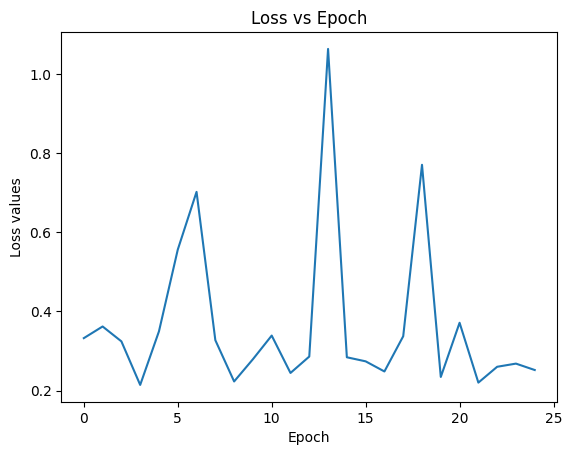

In [39]:
# Training Loss over each iteration
plt.plot(train_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss values')
plt.title('Loss vs Epoch')
plt.show()

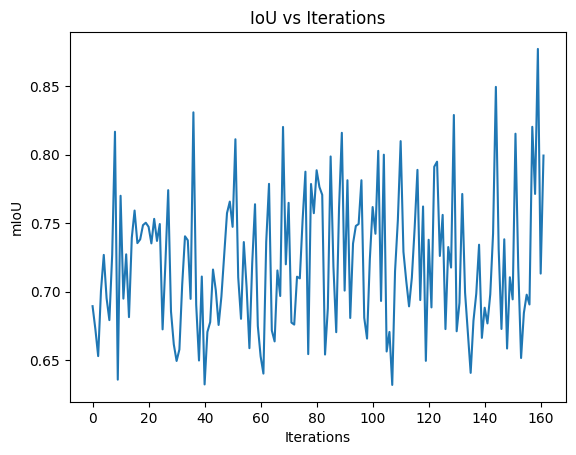

In [47]:
# mIoU for training data over each epoch
plt.plot(avg_iou_train)
plt.xlabel('Iterations')
plt.ylabel('mIoU')
plt.title('IoU vs Iterations')
plt.show()

## Evaluating the Test Data


In [41]:
print('\n---------Evaluation Metrics for Testing--------\n')
print('Testing IoU')
avg_iou_test=[]
# Test dataset
for input_batch, target_batch in test_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_psp(input_batch)

  iou_scores = iou(predict_batch, target_batch)
  avg_iou_test.append(iou_scores)

print("The testing IoU is: ",np.nanmean(avg_iou_test))


---------Evaluation Metrics for Testing--------

Testing IoU
The testing IoU is:  0.6688853662657893


## Looking at Pixel Accuracy

In [43]:
print('\n---------Evaluation Metrics for Testing--------\n')
print('Testing Accuracy')
avg_acc_test=[]
# Test dataset
for input_batch, target_batch in test_loader:

  input_batch=input_batch.to(device)
  target_batch=target_batch.to(device)

  predict_batch = model_psp(input_batch)

  acc_scores = pixel_acc(predict_batch, target_batch)
  avg_acc_test.append(acc_scores)

print("The testing accuracy is: ",np.mean(avg_acc_test))


---------Evaluation Metrics for Testing--------

Testing Accuracy
The testing accuracy is:  0.9199774000379773


## Visualizing some predictions from test data and comparing with target

In [45]:
input_batch, target_batch = next(iter(test_loader))

predict_batch = model_psp(input_batch.to(device))

preds = np.argmax(predict_batch.detach().cpu().numpy(), axis=1)

labels = target_batch.cpu().numpy()

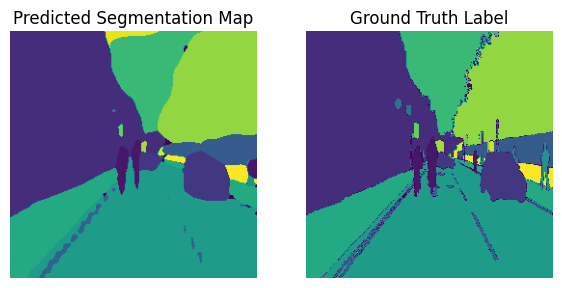

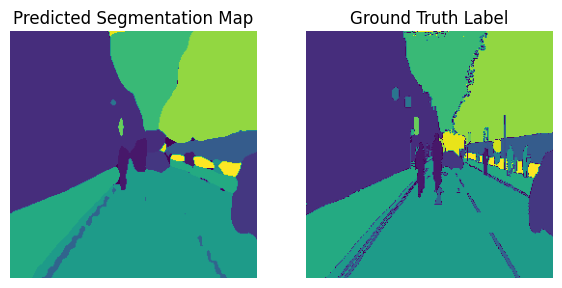

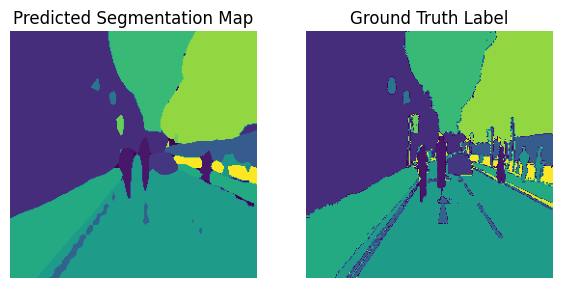

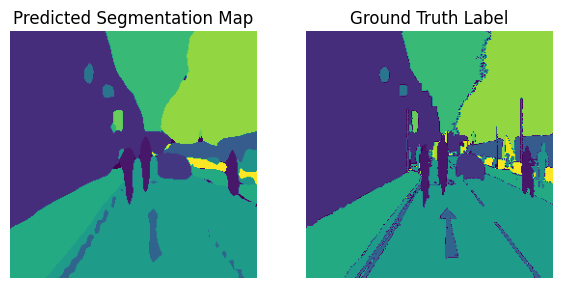

In [46]:
for i in range(4):  
    plt.figure(figsize=(7, 7))
    plt.subplot(121)
    plt.imshow(preds[i])
    plt.axis("off")
    plt.title("Predicted Segmentation Map")
    plt.subplot(122)
    plt.imshow(labels[i])
    plt.axis("off")
    plt.title("Ground Truth Label")
    plt.show()

### The final summary and comparison of different models is done in the report